# Real or Fake Text Data Analysis Notebook

<a href="https://colab.research.google.com/github/kirubarajan/roft/blob/master/annotation/analysis/research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This contains all of the data analysis for the roft platform. There are four main sections:
1. Dataset Loading and Cleaning
2. Dataset Filtering
3. Data Analysis
4. Paper Figures

In [1]:
### Run this cell and then restart the runtime to get latest version of matplotlib and spacy
!pip install fsspec gcsfs
!pip install --upgrade spacy
!pip install --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import json
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.stats
import random
import collections
from scipy import stats as scipystats
import copy
sns.set_theme(style="whitegrid")
sns.set_palette(sns.color_palette("Set2"))

In [3]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [4]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

# 1. Dataset Loading and Cleaning

- Load data from the cloud bucket
- Merge data w/ the survey results
- Process the survey responses
- Remove participants who did not want their data included
- Clean columns and remove unwanted columns

### Load in the Dataframe from the GCloud bucket

In [5]:
DATABASE_DUMP_FILE = 'gs://roft_buckups/6-21-22.json'

with tf.io.gfile.GFile(DATABASE_DUMP_FILE, 'r') as f:
    lines = f.readlines()
    db = json.loads(lines[1])

def get_df(sql_model='core.annotation'):
    df = pd.DataFrame(db)
    df = df[df.model == sql_model]
    
    if 'date' in df.columns.values:
        df = df.set_index('date')

    return pd.json_normalize(df.fields).assign(pk=df.pk.values)

In [6]:
df = pd.DataFrame(db)
print(set(df["model"].tolist()))

{'admin.logentry', 'auth.permission', 'core.decodingstrategy', 'core.profile', 'core.feedbackoption', 'auth.user', 'core.playlist', 'core.annotation', 'sessions.session', 'contenttypes.contenttype', 'core.dataset', 'core.prompt', 'core.system', 'core.timestamp', 'core.generation'}


In [7]:
annotation_df = get_df()
profile_df = get_df('core.profile')
generation_df = get_df('core.generation')
prompt_df = get_df('core.prompt')
playlist_df = get_df('core.playlist')
decodingstrategy_df = get_df('core.decodingstrategy')
user_df = get_df('auth.user')

### Modify column names to avoid duplicates across tables.

In [8]:
prompt_df = prompt_df.rename(columns={"body": "prompt_body"})
generation_df = generation_df.rename(columns={"body": "gen_body"})
decodingstrategy_df = decodingstrategy_df.rename(
    columns={"name": "dec_strat", "value": "dec_strat_value"})
annotation_df["date"] = pd.to_datetime(annotation_df["date"])

### Merge all the relevant tables together.

In [9]:
gen_to_playlist = {}
for idx, row in playlist_df.iterrows():
  shortname = row["shortname"]
  version = row["version"]
  generations = row["generations"]
  for gen_id in generations:
    gen_to_playlist[gen_id] = (shortname, version)

In [10]:
full_df = annotation_df.join(generation_df.set_index('pk'), on='generation')
full_df = full_df.join(prompt_df.set_index('pk'), 'prompt')
full_df = full_df.join(decodingstrategy_df.set_index('pk'), 'decoding_strategy')
full_df = full_df.join(user_df.set_index('pk'), 'annotator')

In [11]:
playlist_names = [] 
playlist_versions = []
for idx, row in full_df.iterrows():
  gen_id = row["generation"]
  playlist_info = gen_to_playlist[gen_id]
  playlist_names.append(playlist_info[0])
  playlist_versions.append(playlist_info[1])
full_df["playlist_name"] = playlist_names
full_df["playlist_version"] = playlist_versions

##Add survey results to the DataFrame

In [12]:
SURVEY_SPREADSHEET_ID = '1j9-nqsGFhpKSas_z1-IRKORlVbmjTzJ4_u_q6u-hOvg'
KEY = "agreed_to_research"
worksheet = gc.open_by_key(SURVEY_SPREADSHEET_ID).sheet1
rows = worksheet.get_all_values()

survey_df = pd.DataFrame.from_records(rows[1:], columns=rows[0])
full_df = full_df.join(survey_df.set_index('username'), 'username', how="inner")

### Process survey responses
Map the familiarity questions to a 1-5 labeling scheme and rename the columns

In [13]:
#@title Process Survey Responses
def remap_familiarity_labels(x):
  if x == "I've never heard of them.":
    return 1
  elif x == "I've read about them in the news or a blog post.":
    return 2
  elif x == "I’ve been excitedly following them.":
    return 3
  elif x == "I’ve used them before (either with the OpenAI API, HuggingFace Transformers, etc.).":
    return 4
  else:
    return -1

def remap_genre_fam_labels(x):
  if x == "Never":
    return 1
  elif x == "Once to a few times per year":
    return 2
  elif x == "Once to a few times per month":
    return 3
  elif x == "Once to a few times per week":
    return 4
  elif x == "Daily":
    return 5
  else:
    return -1

full_df = full_df.rename(columns={"What did you (or what are you planning to) major/minor in?": "major", 
                                  "How often do you consult a recipe when preparing food?": "recipe_familiarity", 
                                  'How often do you read news from credible news publishers (Philadelphia Inquirer, Wall Street Journal, New York Times, etc.)?':'news_familiarity', 
                                  'How often do you read fiction on the internet (fan fiction, creative writing sub-reddits, ebooks, etc.)?':'stories_familiarity',
                                  'What is your familiarity with GPT-2 and GPT-3?':'gen_familiarity',
                                  'Did you read the RoFT Guide before you tried the game?': 'read_guide',
                                  'Are you a native English speaker?': 'english',
                                  "Do you agree for the data being collected on this form along with any annotations you make on the RoFT website to be used in an anonymized, aggregated way for research on students' ability to detect machine-generated text? Your answer on this question will not affect your grade.": 'agreed_to_research'})

full_df['recipe_familiarity'] = full_df['recipe_familiarity'].apply(remap_genre_fam_labels)
full_df['news_familiarity'] = full_df['news_familiarity'].apply(remap_genre_fam_labels)
full_df['stories_familiarity'] = full_df['stories_familiarity'].apply(remap_genre_fam_labels)
full_df['gen_familiarity'] = full_df['gen_familiarity'].apply(remap_familiarity_labels)

### Remove all annotators that did not agree to be included in the study (and ourselves)

**TO HAVE YOUR PROFILE FILTERED OUT, PLEASE FILL OUT THE GOOGLE FORM AND SPECIFY "NO" TO THE QUESTION ABOUT WHETHER YOU WANT TO PARTICIPATE IN RESEARCH.**

In [14]:
# Filter all of the data frames that we use for analysis.
full_df = full_df[full_df['agreed_to_research'] == 'Yes']
annotation_df = annotation_df[annotation_df.annotator.isin(full_df['username'])]

### Process Majors
Parse the free text responses into one of 34 different major codes

In [15]:
#@title Majors { display-mode: "form" }
def process_major(x):
  major_labels = []
  CIS = ['Computer and Information Science', 'CIS', 'Computer Science', 'Computer science', 'CS', 'Comp sci', 'computer science', 'cis', 'CSCI']
  MCIT = ['MICT', 'MCIT', 'Computer and Information Technology', 'Information Technology', 'Computer & Information Technology', 'Computer and information tech', 'mcit', 'OMCIT', 'Computer and Information Tech', 'Computer Information and Technology', 'Computer Information Technology', 'Computer and Info Tech', 'CIT', 'computer information technology', 'Computer Science and information Technology', 'cit']
  FIN = ['Finance', 'finance', 'Business Analytics']
  ACCT = ['accounting', 'Accounting']
  BA = ['Business Administration']
  QM = ['quantitative methods']
  CMPE = ['Computer Engineering']
  PHYS = ['Physics', 'physics']
  COM = ['Communications', 'communications']
  COG = ['cognitive science', 'Cognitive Science']
  CBIO = ['Computational Biology']
  ROBO = ['ROBO', 'Robotics']
  LING = ['Linguistics', 'LING']
  EE = ['Environmental Engineering']
  ESE = ['ESE', 'electrical engineering', 'EE']
  NETS = ['NETS', 'Networked and Social Systems Engineering', 'Systems Engineering']
  DATS = ['Data Science', 'data science', 'DATS']
  BIO = ['Biology', 'biology']
  ARTH = ['Art History']
  HIST = ['History', 'history', 'HIST']
  PHIL = ['Philosophy']
  ENT = ['Entrepreneurship']
  DMD = ['DMD', 'Digital Media Design']
  MATH = ['MATH', 'math', 'mathematics', 'Mathematics']
  MED = ['medicine']
  NEURO = ['neuroscience', 'Neuroscience']
  BE = ['BE', 'bioengineering', 'Bioengineering']
  CBE = ['Chemical Engineering']
  CIV = ['civil engineering', 'Civil Engineer']
  MEAM = ['MEAM', 'mechanical engineering', 'Mechanical Engineering']
  ECON = ['Economics', 'ECON']
  CGGT = ['CGGT', 'Computer Graphics and Game Technology']
  SCMP = ['Scientific Computing']

  if any(substring in x for substring in CIS):
    major_labels.append("CIS")
  if any(substring in x for substring in MCIT):
    major_labels.append("MCIT")
  if any(substring in x for substring in FIN):
    major_labels.append("FIN")
  if any(substring in x for substring in ACCT):
    major_labels.append("ACCT")
  if any(substring in x for substring in BA):
    major_labels.append("BA")
  if any(substring in x for substring in QM):
    major_labels.append("QM")
  if any(substring in x for substring in PHYS):
    major_labels.append("PHYS")
  if any(substring in x for substring in COM):
    major_labels.append("COM")
  if any(substring in x for substring in COG):
    major_labels.append("COG")
  if any(substring in x for substring in CBIO):
    major_labels.append("CBIO")
  if any(substring in x for substring in ROBO):
    major_labels.append("ROBO")
  if any(substring in x for substring in LING):
    major_labels.append("LING")
  if any(substring in x for substring in EE):
    major_labels.append("EE")
  if any(substring in x for substring in ESE):
    major_labels.append("ESE")
  if any(substring in x for substring in NETS):
    major_labels.append("NETS")
  if any(substring in x for substring in DATS):
    major_labels.append("DATS")
  if any(substring in x for substring in BIO):
    major_labels.append("BIO")
  if any(substring in x for substring in ARTH):
    major_labels.append("ARTH")
  if any(substring in x for substring in HIST):
    major_labels.append("HIST")
  if any(substring in x for substring in PHIL):
    major_labels.append("PHIL")
  if any(substring in x for substring in ENT):
    major_labels.append("ENT")
  if any(substring in x for substring in DMD):
    major_labels.append("DMD")
  if any(substring in x for substring in MATH):
    major_labels.append("MATH")
  if any(substring in x for substring in MED):
    major_labels.append("MED")
  if any(substring in x for substring in NEURO):
    major_labels.append("NEURO")
  if any(substring in x for substring in BE):
    major_labels.append("BE")
  if any(substring in x for substring in CIV):
    major_labels.append("CIV")
  if any(substring in x for substring in MEAM):
    major_labels.append("MEAM")
  if any(substring in x for substring in ECON):
    major_labels.append("ECON")
  if any(substring in x for substring in CGGT):
    major_labels.append("CGGT")
  if any(substring in x for substring in CMPE):
    major_labels.append("CMPE")
  if any(substring in x for substring in CBE):
    major_labels.append("CBE")
  if any(substring in x for substring in SCMP):
    major_labels.append("SCMP")

  if x == 'Engineering':
    major_labels.append("ENG")
  if x == 'Computer':
    major_labels.append("MCIT")
  if x == 'AI':
    major_labels.append("AI")
  if x == 'urban planning':
    major_labels.append('URB')
  if x == 'Stories':
    major_labels.append('STOR')

  return major_labels

full_df['major'] = full_df['major'].apply(process_major)

## Final Cleanup
Rename columns, delete unused columns, etc.

In [16]:
def clean_up_columns(df):

  columns_to_drop = ['attention_check', 'dec_strat', 'password', 'last_login', 'is_superuser', 'is_staff', 'first_name', 'last_name', 'email', 'is_active', 'groups', 'user_permissions', 'agreed_to_research', 'dataset', 'decoding_strategy']
  df = df.drop(columns_to_drop, axis=1)

  df = df.rename(columns={'system':'model','playlist_name':'dataset', 'boundary':'predicted_boundary_index', 'num_sentences':'true_boundary_index'})
  df['true_boundary_index'] = df['true_boundary_index'] - 1
  return df
  
full_df = clean_up_columns(full_df)

## Filtering

In [17]:
full_df_gpt3 = full_df[full_df.apply(lambda row: row["playlist_version"]=="0.6", axis=1)]

In [18]:
full_df_gpt3

,date,annotator,generation,playlist,predicted_boundary_index,points,reason,pk,model,prompt,...,playlist_version,Timestamp,Email Address,major,english,recipe_familiarity,news_familiarity,stories_familiarity,gen_familiarity,read_guide
47420,2022-05-20 04:06:31.214000+00:00,13421,34098,14,1,0,[common_sense],51910,davinci,23976,...,0.6,5/22/2022 19:22:47,chenmcao@seas.upenn.edu,[CIS],No,3,3,3,1,Yes
47421,2022-05-20 04:08:16.802000+00:00,13421,34222,14,3,0,[grammar],51911,davinci,24100,...,0.6,5/22/2022 19:22:47,chenmcao@seas.upenn.edu,[CIS],No,3,3,3,1,Yes
47422,2022-05-20 04:09:23.947000+00:00,13421,34940,14,1,0,[common_sense],51912,davinci,24819,...,0.6,5/22/2022 19:22:47,chenmcao@seas.upenn.edu,[CIS],No,3,3,3,1,Yes
47423,2022-05-20 04:10:10.956000+00:00,13421,34482,14,4,5,[repetition],51913,davinci,24360,...,0.6,5/22/2022 19:22:47,chenmcao@seas.upenn.edu,[CIS],No,3,3,3,1,Yes
47424,2022-05-20 04:12:21.528000+00:00,13421,35464,14,9,4,[],51914,gpt2-xl,25343,...,0.6,5/22/2022 19:22:47,chenmcao@seas.upenn.edu,[CIS],No,3,3,3,1,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59271,2022-06-15 04:04:04.486000+00:00,15157,33766,14,1,5,[contradicts_knowledge],63761,davinci,23644,...,0.6,6/29/2022 1:18:02,jdgrimes@seas.upenn.edu,"[CIS, ECON]",Yes,2,5,2,2,Yes
59272,2022-06-15 04:04:41.759000+00:00,15157,34393,14,4,5,[common_sense],63762,davinci,24271,...,0.6,6/29/2022 1:18:02,jdgrimes@seas.upenn.edu,"[CIS, ECON]",Yes,2,5,2,2,Yes
59273,2022-06-15 04:06:42.822000+00:00,15157,35575,14,9,5,[],63763,gpt2-xl,25454,...,0.6,6/29/2022 1:18:02,jdgrimes@seas.upenn.edu,"[CIS, ECON]",Yes,2,5,2,2,Yes
59328,2022-06-17 01:47:17.198000+00:00,15157,34441,14,2,0,[repetition],63818,davinci,24319,...,0.6,6/29/2022 1:18:02,jdgrimes@seas.upenn.edu,"[CIS, ECON]",Yes,2,5,2,2,Yes


### Filter out annotations not part of Version 2

In [19]:
full_df = full_df[full_df.apply(lambda row: row["playlist_version"]=="0.2", axis=1)]

In [20]:
original_df = copy.deepcopy(full_df)

### Filter out annotators we don't like.
ID 4334 used exploits and other scripts to manipulate the site.

In [21]:
full_df = full_df[~full_df['annotator'].isin([4334])]

### Filter out the extra all-human examples from Recipes

In [22]:
import random
import collections
recipe_frequencies = collections.Counter(full_df[full_df["dataset"]=="Recipes"]["true_boundary_index"])
print("Before filtering: " + str(recipe_frequencies))
avg_freq_non_final = int(np.round(np.mean([recipe_frequencies[i] for i in range(10)])))

random.seed(2342)
def filter_fn(row):
  if (row["dataset"] == "Recipes") and (row["true_boundary_index"] == 9):
    return random.random() < (avg_freq_non_final / recipe_frequencies[9])
  else:
    return True
full_df = full_df[full_df.apply(filter_fn, axis=1)]
recipe_frequencies = collections.Counter(full_df[full_df["dataset"]=="Recipes"]["true_boundary_index"])
print("After filtering: " + str(recipe_frequencies))

Before filtering: Counter({9: 2876, 0: 1221, 2: 1214, 3: 1119, 4: 1111, 5: 1107, 1: 1099, 6: 785, 7: 726, 8: 721})
After filtering: Counter({0: 1221, 2: 1214, 9: 1172, 3: 1119, 4: 1111, 5: 1107, 1: 1099, 6: 785, 7: 726, 8: 721})


###Filter out all spans of 5 annotations that were the same exact value:

In [23]:
def is_percentage(annotations, percentage):
  counter = collections.Counter(annotations)
  percent_list = [(counter[i] / len(annotations)) >= percentage for i in range(10)]
  return any(percent_list)

def sliding_window(df, annotator, percentage, n):
  # This function returns all indices where any window of length n +/- that index is over percentage
  # amount a single value
  indices_to_remove = set()
  ann_list = df[df["annotator"] == annotator].sort_values("date")["predicted_boundary_index"]
  if len(ann_list) < n: 
    return set()
  for i in range(len(ann_list) - n):
    if is_percentage(ann_list[i:i+n], percentage):
      indices_to_remove = indices_to_remove.union(set(ann_list[i:i+n].index.tolist()))
  return indices_to_remove

annotators = set(full_df["annotator"].tolist())
indices_to_remove = set()
for a in annotators:
  indices_to_remove = indices_to_remove.union(sliding_window(full_df, a, 1, 5))

print("Total number of annotations in the data: " + str(len(full_df)))
print("Number of Annotations kept: " + str(len(full_df[~full_df.index.isin(indices_to_remove)])))
print("Number of Annotations removed: " + str(len(indices_to_remove)))
print(len(annotators))

full_df = full_df[~full_df.index.isin(indices_to_remove)]

Total number of annotations in the data: 23977
Number of Annotations kept: 20324
Number of Annotations removed: 3653
247


In [24]:
full_df = full_df[~full_df.index.isin(indices_to_remove)]

## Recover CTRL Labels
In our original analysis we lost the distinction between when a speech was generated with control code and without a control code. This bit of code recovers that information.

In [25]:
CTRL_GEN_FILES_NOCODE = ['gs://roft_datasets/generations_v3/speeches/generations-ctrl-nocode-speeches-dev.json', 
                                                         'gs://roft_datasets/generations_v3/speeches/generations-ctrl-nocode-speeches-train.json', 
                                                         'gs://roft_datasets/generations_v3/speeches/generations-ctrl-nocode-speeches-test.json']
CTRL_GEN_FILES_CODE = ['gs://roft_datasets/generations_v3/speeches/generations-ctrl-Politics-speeches-dev.json', 
                                                   'gs://roft_datasets/generations_v3/speeches/generations-ctrl-Politics-speeches-train.json', 
                                                   'gs://roft_datasets/generations_v3/speeches/generations-ctrl-Politics-speeches-test.json']

reverse_lookup_dict = dict()
for fname in CTRL_GEN_FILES_CODE:
  with tf.io.gfile.GFile(fname, 'r') as f:
    gen_data = json.load(f)
    for gen in gen_data['generations']:
      # Insert the first generated sentence into the dictionary as key. 
      # Value is a boolean. True = generation was made w/ Politics control code
      # Reasoning for try block is in the case of all-human examples
      try: reverse_lookup_dict[gen['generation'][0]] = True
      except IndexError: pass

for fname in CTRL_GEN_FILES_NOCODE:
  with tf.io.gfile.GFile(fname, 'r') as f:
    gen_data = json.load(f)
    for gen in gen_data['generations']:
      # Insert the first generated sentence into the dictionary as key. 
      # Value is a boolean. True = generation was made w/ Politics control code
      try: reverse_lookup_dict[gen['generation'][0]] = False
      except IndexError: pass

print(reverse_lookup_dict)

{'This is a great opportunity for me as your Vice President.': True, 'The Almighty has given us a country for our use as long as we shall live in it': True, 'I have just returned from a trip that took me around the world.   ': True, 'In these two nations we are privileged to meet with representatives who represent some 30 million people -- one third of our total population.': True, 'In this new situation we are placed between two hostile powers.': False, 'But today there are two things which make this occasion particularly solemn.': True, 'The acts of Congress relating thereto, however, have been, from time to time, renewed with varying modifications in each of these States.   ': True, 'We have seen how difficult it can be to recover from natural disasters.': True, 'He began his speech with these words:   "Mr. Speaker: At this time, it is more important than ever before to make sure we are working together toward an American foreign policy which will bring peace and prosperity to all p

In [26]:
# Use the reverse lookup dict to reassign labels for the CTRL generations
# (If all human then randomly assign to either)
def reassign_ctrl_label(x):
  new_model_label = x['model']
  if x['model'] == 'ctrl':
    if x['gen_body']:
      if reverse_lookup_dict[x['gen_body'].split('_SEP_')[0]]:
        new_model_label = 'ctrl-Politics'
      else:
        new_model_label = 'ctrl-nocode'
    else:
      if random.random() > 0.5:
        new_model_label = 'ctrl-Politics'
      else:
        new_model_label = 'ctrl-nocode'
  return new_model_label

random.seed(42)
full_df['model'] = full_df.apply(reassign_ctrl_label, axis=1)

## Replace all human examples with 'human' model

So that the all human examples do not interfere with our analysis

In [27]:
def reassign_all_human_model(x):
  if x['gen_body']:
    return x['model']
  else:
    return 'human'

full_df['model'] = full_df.apply(reassign_all_human_model, axis=1)

# Helper Functions

In [28]:
import scipy.stats

def mean_confidence_interval_me(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    left, right = scipy.stats.norm.interval(alpha=confidence,loc=m, scale=se)
    return round(left - m, 5), round(right - m, 5)

def map_playlist_name(playlist):
  """Converts playlist names to the ones we want to use in the paper."""
  if playlist == 'New York Times':
    return "News"
  elif playlist == 'Presidential Speeches':
    return "Speeches"
  elif playlist == 'Recipes':
    return "Recipes"
  elif playlist == 'Short Stories':
    return "Stories"

def map_p_value(x):
  "Converts float p values to the naames we want to use in the paper."""
  if x >= 0:
    return "$p={}$".format(x)
  else:
    return "sanity"

def save(filename):
  plt.tight_layout()
  plt.savefig(filename)
  plt.show()

def find_frequent_annotators(df, min_n=10):
  """Retrieve a list of annotators who have done a minimum number of annotations."""
  
  annotators = []

  for annotator in set(df["annotator"].tolist()):
    points = df[df["annotator"] == annotator]["points"].tolist()
    
    if len(points) >= min_n:
      annotators.append(annotator)

  return annotators

freq20_annotators = find_frequent_annotators(full_df, 20)
full_df_freq20 = full_df[full_df["annotator"].isin(freq20_annotators)]

freq10_annotators = find_frequent_annotators(full_df, 10)
full_df_freq10 = full_df[full_df["annotator"].isin(freq10_annotators)]

# Dataset Statistics

## Counts

In [29]:
full_df.groupby('dataset').count()

,date,annotator,generation,playlist,predicted_boundary_index,points,reason,pk,model,prompt,...,playlist_version,Timestamp,Email Address,major,english,recipe_familiarity,news_familiarity,stories_familiarity,gen_familiarity,read_guide
dataset,,,,,,,,,,,,,,,,,,,,,
New York Times,3319,3319,3319,3319,3319,3319,3319,3319,3319,3319,...,3319,3319,3319,3319,3319,3319,3319,3319,3319,3319
Presidential Speeches,4846,4846,4846,4846,4846,4846,4846,4846,4846,4846,...,4846,4846,4846,4846,4846,4846,4846,4846,4846,4846
Recipes,7887,7887,7887,7887,7887,7887,7887,7887,7887,7887,...,7887,7887,7887,7887,7887,7887,7887,7887,7887,7887
Short Stories,4272,4272,4272,4272,4272,4272,4272,4272,4272,4272,...,4272,4272,4272,4272,4272,4272,4272,4272,4272,4272


In [30]:
original_df.groupby('dataset').count()

,date,annotator,generation,playlist,predicted_boundary_index,points,reason,pk,model,prompt,...,playlist_version,Timestamp,Email Address,major,english,recipe_familiarity,news_familiarity,stories_familiarity,gen_familiarity,read_guide
dataset,,,,,,,,,,,,,,,,,,,,,
New York Times,3679,3679,3679,3679,3679,3679,3679,3679,3679,3679,...,3679,3679,3679,3679,3679,3679,3679,3679,3679,3679
Presidential Speeches,5190,5190,5190,5190,5190,5190,5190,5190,5190,5190,...,5190,5190,5190,5190,5190,5190,5190,5190,5190,5190
Recipes,12084,12084,12084,12084,12084,12084,12084,12084,12084,12084,...,12084,12084,12084,12084,12084,12084,12084,12084,12084,12084
Short Stories,4900,4900,4900,4900,4900,4900,4900,4900,4900,4900,...,4900,4900,4900,4900,4900,4900,4900,4900,4900,4900


## Decoding Strategies

In [31]:
df = full_df.groupby(['dataset', 'dec_strat_value']).count()
df = df.reset_index()

In [32]:
values = [-1, 0.0, 0.4, 1.0]

def get_dec_strat_counts(dataset):
  df2 = df[df["dataset"]==dataset].filter(items=["dataset", "dec_strat_value", "pk"])
  counts = [df2[df2["dec_strat_value"]==v]["pk"].tolist() for v in values]
  counts = [c[0] if c else 0 for c in counts]
  return counts

nytimes_counts = get_dec_strat_counts("New York Times")


In [33]:
df2 = df.filter(items=["dataset", "dec_strat_value", "pk"])
df2 = df2.groupby(['dataset', 'dec_strat_value']).sum().unstack()
df2 = df2.fillna(0)
df2.columns = [str(a[-1]) for a in df2.columns.to_flat_index()]

sums = df2.sum(axis=1)
df2["-1.0"] = df2["-1.0"] / sums
df2["0.0"] = df2["0.0"] / sums
df2["0.4"] = df2["0.4"] / sums
df2["1.0"] = df2["1.0"] / sums

df2 = df2.reset_index()
df2

,dataset,-1.0,0.0,0.4,1.0
0,New York Times,0.065381,0.329316,0.290449,0.314854
1,Presidential Speeches,0.000000,0.000000,1.000000,0.000000
2,Recipes,0.000000,0.000000,1.000000,0.000000
3,Short Stories,0.000000,0.087079,0.827949,0.084972


Short Stories


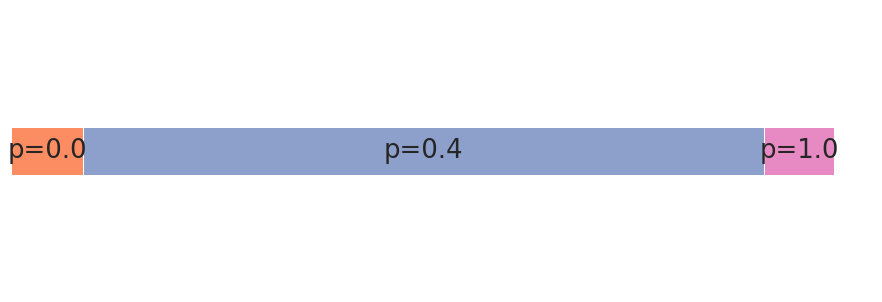

Recipes


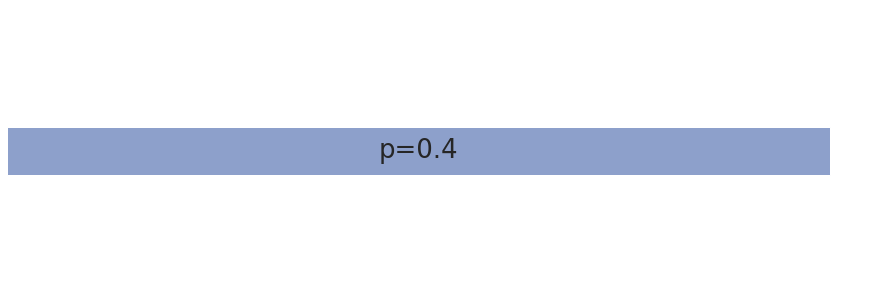

New York Times


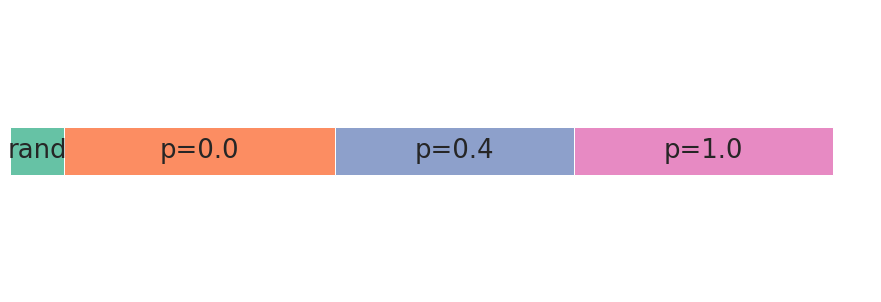

Presidential Speeches


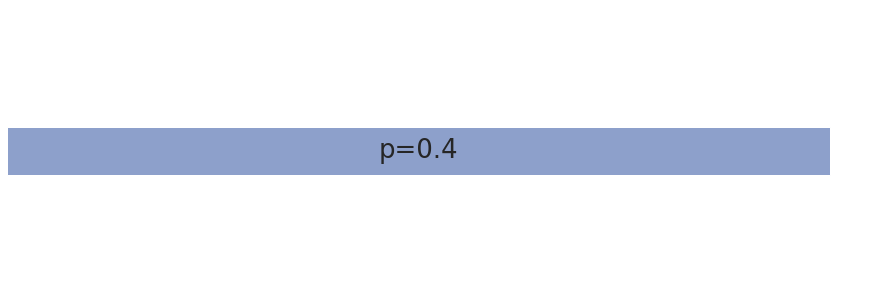

<AxesSubplot: >

In [34]:
def decide_label(i):
  v = float(values[i])
  if v >= 0:
    return "p={}".format(v)
  else:
    return "rand"

def plot(dataset):
  print(dataset)
  ax = plt.figure(figsize=[12, 4]).subplots(1, 1)

  df3 = df2[df2["dataset"]==dataset]
  ax = df3.plot(kind='barh', stacked=True, width=0.1, ax=ax)

  for i, c in enumerate(ax.containers):
    labels = [decide_label(i) if v.get_width() > 0.0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', fontsize=26)
    
  ax.get_legend().remove()
  plt.grid(False)
  plt.axis('off')
  plt.tight_layout()
  ax.set_position((0, 0, 1, 1))
  ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator())
  ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator())

  # plt.savefig("decoding_dist_{}.pdf".format(dataset.lower().replace(" ", "_")), transparent=True)
  plt.show()
  return ax

plot("Short Stories")
plot("Recipes")
plot("New York Times")
plot("Presidential Speeches")

## Models

In [35]:
df = full_df.groupby(['dataset', 'model']).count()
df = df.reset_index()

values = [-1, 0.0, 0.4, 1.0]

df2 = df.filter(items=["dataset", "model", "pk"])
df2 = df2.groupby(['dataset', 'model']).sum().unstack()
df2 = df2.fillna(0)
df2.columns = [str(a[-1]) for a in df2.columns.to_flat_index()]

sums = df2.sum(axis=1)
for col in set(df2.columns) - {"dataset"}:
  df2[col] = df2[col] / sums

models_per_dataset = {
 "New York Times": ["easy", "gpt2-xl", "human"],
 "Presidential Speeches": ["ctrl-Politics", "ctrl-nocode", "human"],
 "Recipes": ["finetuned", "gpt2-xl", "human"],
 "Short Stories": ["gpt2", "gpt2-xl", "human"]   
}


df2 = df2.reset_index()
df2

,dataset,ctrl-Politics,ctrl-nocode,davinci,easy,finetuned,gpt2,gpt2-xl,human
0,New York Times,0.000000,0.000000,0.000000,0.059054,0.000000,0.000000,0.805062,0.135884
1,Presidential Speeches,0.542303,0.337392,0.000000,0.000000,0.000000,0.000000,0.000000,0.120305
2,Recipes,0.000000,0.000000,0.000000,0.000000,0.665018,0.000000,0.218714,0.116267
3,Short Stories,0.000000,0.000000,0.016386,0.000000,0.000000,0.581695,0.224719,0.177200


Short Stories


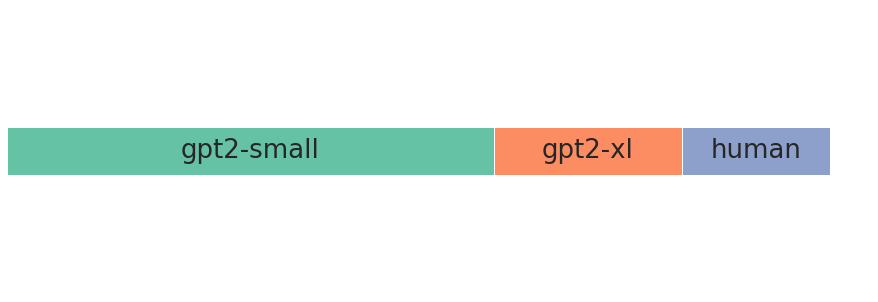

Recipes


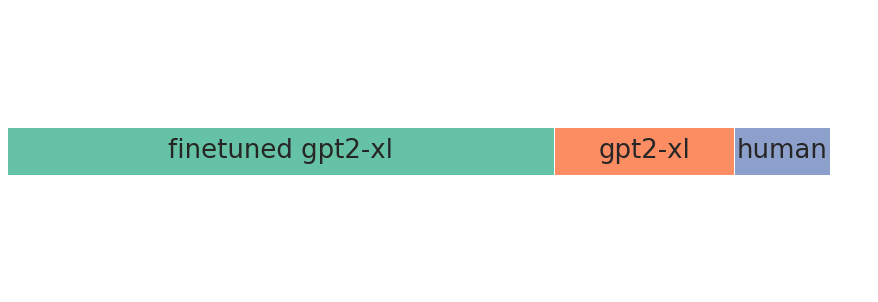

New York Times


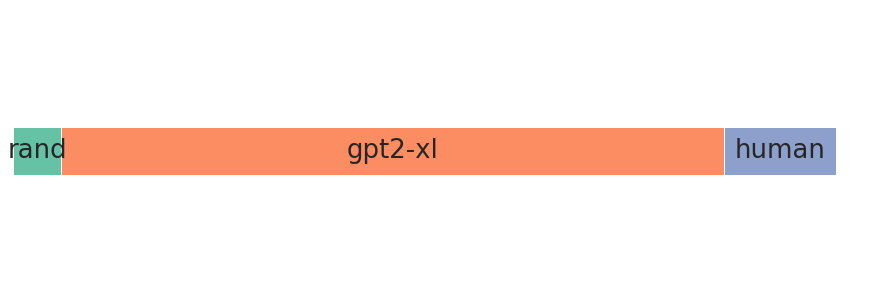

Presidential Speeches


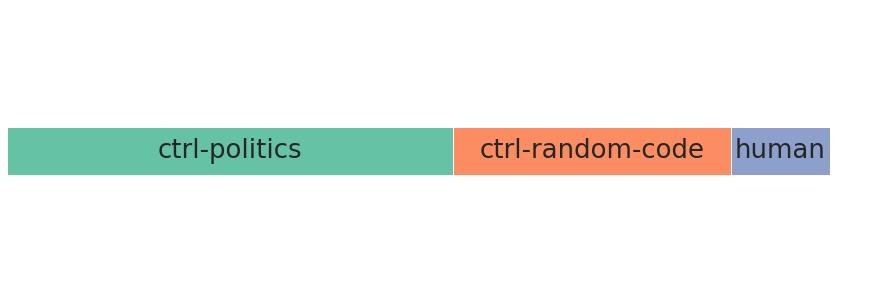

<AxesSubplot: >

In [36]:
def decide_label(dataset, i):
  name = models_per_dataset[dataset][i]

  name_remap = {
      "gpt2": "gpt2-small",
      "ctrl-nocode": "ctrl-random-code",
      "ctrl-Politics": "ctrl-politics",
      "finetuned": "finetuned gpt2-xl",
      "easy": "rand"
  }

  return name_remap.get(name, name)

def plot(dataset):
  print(dataset)
  ax = plt.figure(figsize=[12, 4]).subplots(1, 1)

  df3 = df2[df2["dataset"]==dataset][models_per_dataset[dataset]]
  ax = df3.plot(kind='barh', stacked=True, width=0.1, ax=ax)

  for i, c in enumerate(ax.containers):
    labels = [decide_label(dataset, i) if v.get_width() > 0.0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', fontsize=26)
  ax.get_legend().remove()
  plt.grid(False)
  plt.axis('off')
  plt.tight_layout()
  ax.set_position((0, 0, 1, 1))
  ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator())
  ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator())

  plt.savefig("model_dist_{}.pdf".format(dataset.lower().replace(" ", "_")), transparent=True)
  plt.show()
  return ax

plot("Short Stories")
plot("Recipes")
plot("New York Times")
plot("Presidential Speeches")

## Boundary Distributions

In [37]:
def plot_boundary_distribution(dataset, ax, df, dataset_name, boundary_name):

  boundaries = df[df[dataset_name]==dataset][boundary_name].tolist()
  boundaries = collections.Counter(boundaries)

  if boundary_name == "num_sentences":
    data = [boundaries.get(i) for i in range(1,11)]
    labels = range(1,11)
  else:
    data = [boundaries.get(i) for i in range(10)]
    labels = range(10)

  ax.pie(data, labels=labels, autopct='%.0f%%')
  ax.set_title(map_playlist_name(dataset))

In [38]:
df = generation_df
df["gen_pk"] = df["pk"]
df = df.join(prompt_df.set_index("pk"), on="prompt")

playlist_names = [] 
playlist_versions = []
for idx, row in df.iterrows():
  gen_id = row["gen_pk"]
  playlist_info = gen_to_playlist[gen_id]
  playlist_names.append(playlist_info[0])
  playlist_versions.append(playlist_info[1])
df["playlist_name"] = playlist_names
df["playlist_version"] = playlist_versions
df = df[df["playlist_version"] == "0.2"]

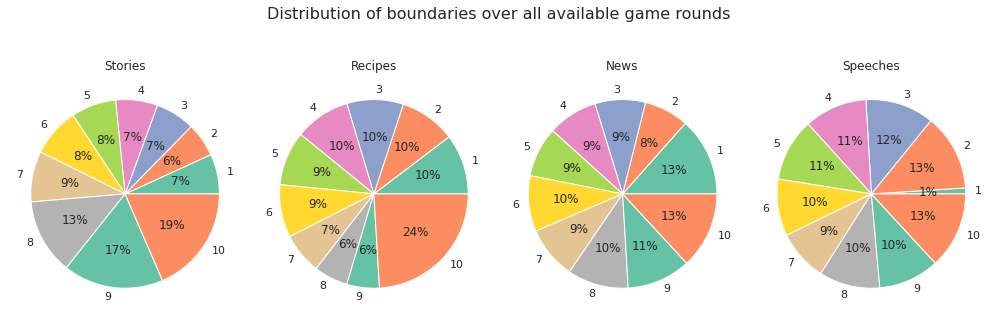

In [39]:
fig = plt.figure(figsize=[14, 5])
axes = fig.subplots(1, 4)
plot_boundary_distribution("Short Stories", axes[0], df, "playlist_name", "num_sentences")
plot_boundary_distribution("Recipes", axes[1], df, "playlist_name", "num_sentences")
plot_boundary_distribution("New York Times", axes[2], df, "playlist_name", "num_sentences")
plot_boundary_distribution("Presidential Speeches", axes[3], df, "playlist_name", "num_sentences")
fig.suptitle('Distribution of boundaries over all available game rounds', fontsize=16)
plt.tight_layout()
plt.savefig("available_game_rounds.pdf")
plt.show()

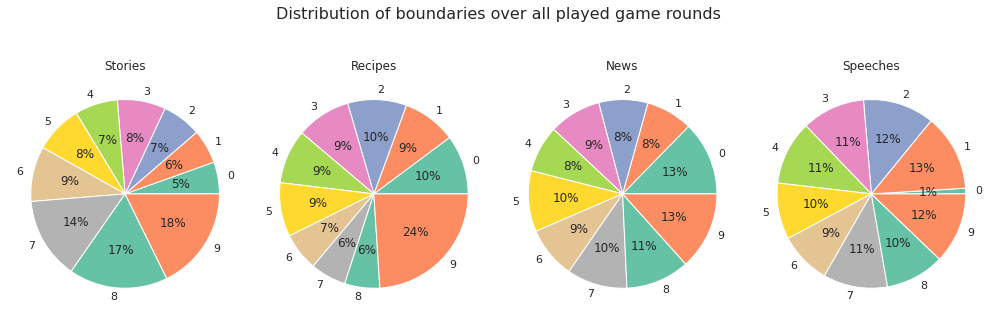

In [40]:
fig = plt.figure(figsize=[14, 5])
axes = fig.subplots(1, 4)
plot_boundary_distribution("Short Stories", axes[0], original_df, "dataset", "true_boundary_index")
plot_boundary_distribution("Recipes", axes[1], original_df, "dataset", "true_boundary_index")
plot_boundary_distribution("New York Times", axes[2], original_df, "dataset", "true_boundary_index")
plot_boundary_distribution("Presidential Speeches", axes[3], original_df, "dataset", "true_boundary_index")
fig.suptitle('Distribution of boundaries over all played game rounds', fontsize=16)
plt.tight_layout()
plt.savefig("played_game_rounds.pdf")
plt.show()

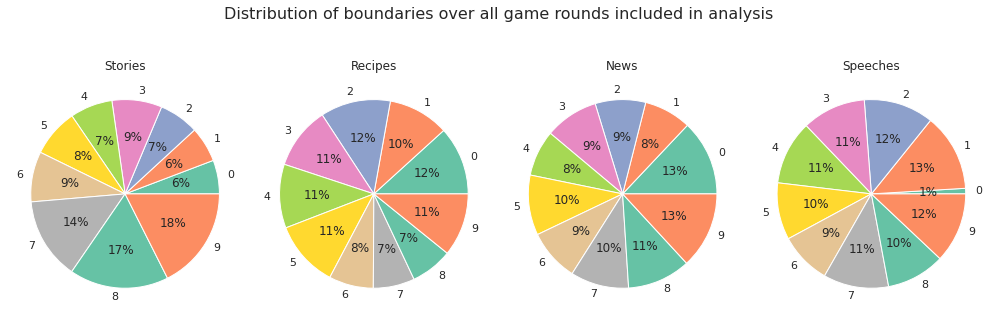

In [41]:
fig = plt.figure(figsize=[14, 5])
axes = fig.subplots(1, 4)
plot_boundary_distribution("Short Stories", axes[0], full_df, "dataset", "true_boundary_index")
plot_boundary_distribution("Recipes", axes[1], full_df, "dataset", "true_boundary_index")
plot_boundary_distribution("New York Times", axes[2], full_df, "dataset", "true_boundary_index")
plot_boundary_distribution("Presidential Speeches", axes[3], full_df, "dataset", "true_boundary_index")
fig.suptitle('Distribution of boundaries over all game rounds included in analysis', fontsize=16)
plt.tight_layout()
plt.savefig("analyzed_game_rounds.pdf")
plt.show()

## Histogram of Predicted Boundaries

<AxesSubplot: title={'center': 'Index of Predicted Boundary Group 1'}, ylabel='Frequency'>

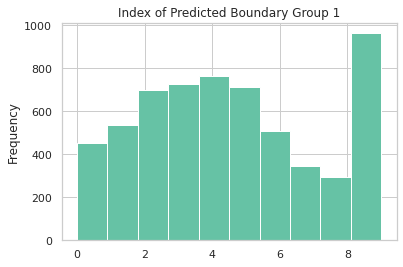

In [42]:
full_df[(full_df['date'] < '2021-10-1')].predicted_boundary_index.plot.hist(
    title='Index of Predicted Boundary Group 1'
)

<AxesSubplot: title={'center': 'Index of Predicted Boundary Group 2'}, ylabel='Frequency'>

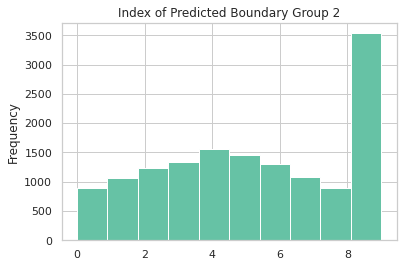

In [43]:
full_df[(full_df['date'] > '2021-10-1') ].predicted_boundary_index.plot.hist(
    title='Index of Predicted Boundary Group 2'
)

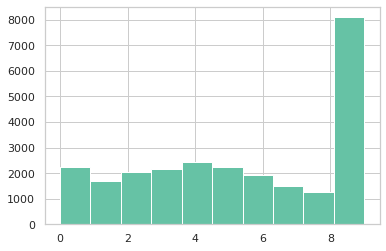

In [44]:
original_df[~original_df['annotator'].isin([4334])].predicted_boundary_index.plot.hist()
plt.ylabel('')
plt.savefig('histogram.pdf')

## Histogram of Mean Score by annotator

# Final graphs for paper

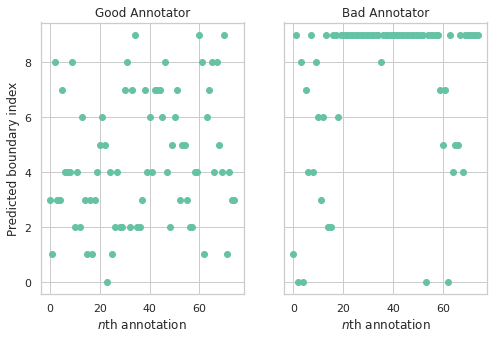

In [45]:
fig = plt.figure(figsize=[8, 5])
axes = fig.subplots(1, 2, sharey=True)
ys1 = original_df[original_df["annotator"] == 5409].sort_values("date")["predicted_boundary_index"].tolist()
ys2 = original_df[original_df["annotator"] == 5411].sort_values("date")["predicted_boundary_index"].tolist()
axes[0].scatter(x=range(75), y=ys1[:75])
axes[1].scatter(x=range(75), y=ys2[:75])
axes[0].set_title("Good Annotator")
axes[0].set(xlabel="$n$th annotation", ylabel="Predicted boundary index")
axes[1].set_title("Bad Annotator")
axes[1].set(xlabel="$n$th annotation")

plt.savefig("goodvsbad.pdf")
plt.show()

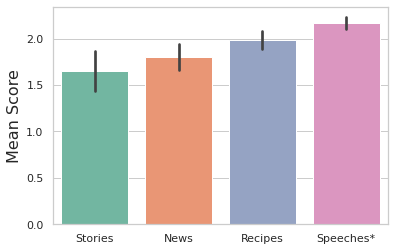

In [46]:
filtered_df = full_df[((full_df["model"]=="gpt2-xl") | (full_df["model"]=="ctrl-Politics") | (full_df["model"]=="ctrl-nocode")) & 
                      (full_df["dec_strat_value"]==0.4)]
filtered_df = copy.deepcopy(filtered_df)
filtered_df["model"] = filtered_df["model"].apply(lambda x: "ctrl" if "ctrl" in x else x)
filtered_df["dec_strat_value"] = filtered_df["dec_strat_value"].apply(map_p_value)
filtered_df["dataset"] = filtered_df["dataset"].apply(map_playlist_name)
filtered_df["dataset"] = filtered_df["dataset"].apply(lambda x: "Speeches*" if "Speeches" in x else x)

# p = sns.barplot(x="dataset", y="points", data=filtered_df, order=["News", "Stories", "Recipes"])
p = sns.barplot(x="dataset", y="points", data=filtered_df, order=["Stories", "News", "Recipes", "Speeches*"])

p.set_title("")
p.set_xlabel("")

matplotlib.rc('xtick', labelsize=12) 
p.set_ylabel("Mean Score", fontsize = 16)
plt.savefig("genre.pdf")

                                  date  annotator  generation playlist  \
649   2021-09-02 15:24:14.917000+00:00       1699       18922       -1   
11467 2021-09-08 06:16:42.033000+00:00       1699       14763       -1   
11693 2021-09-08 07:14:09.934000+00:00       1699        5711        5   
14373 2021-09-11 17:40:50.153000+00:00       1699       12075       -1   
14377 2021-09-11 17:43:45.799000+00:00       1699       20691       -1   
...                                ...        ...         ...      ...   
57755 2022-06-03 03:52:34.949000+00:00      14138        6033       -1   
57910 2022-06-03 05:12:01.202000+00:00      14138       18869       -1   
57916 2022-06-03 05:16:27.719000+00:00      14138       10896       -1   
57917 2022-06-03 05:17:13.352000+00:00      14138       18477       -1   
57961 2022-06-03 05:46:09.231000+00:00      14138       20370       -1   

       predicted_boundary_index  points                   reason     pk  \
649                           3     

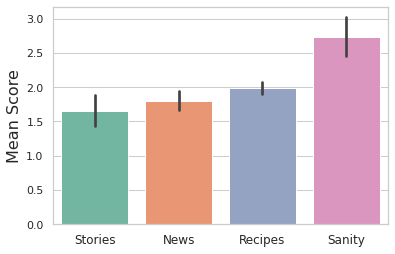

In [47]:
filtered_df = full_df[((full_df["model"]=="gpt2-xl") & (full_df["dec_strat_value"]==0.4)) | (full_df["model"]=="easy")]
filtered_df = copy.deepcopy(filtered_df)
filtered_df["dec_strat_value"] = filtered_df["dec_strat_value"].apply(map_p_value)
filtered_df["dataset"] = filtered_df["dataset"].apply(map_playlist_name)
filtered_df["dataset"] = filtered_df.apply(lambda x: "Sanity" if x["model"] == "easy" else x["dataset"], axis=1)

print(filtered_df)
# p = sns.barplot(x="dataset", y="points", data=filtered_df, order=["News", "Stories", "Recipes"])
p = sns.barplot(x="dataset", y="points", data=filtered_df, order=["Stories", "News", "Recipes", "Sanity"])

p.set_title("")
p.set_xlabel("")

matplotlib.rc('xtick', labelsize=12) 
p.set_ylabel("Mean Score", fontsize = 16)
plt.savefig("genre-with-sanity.pdf")

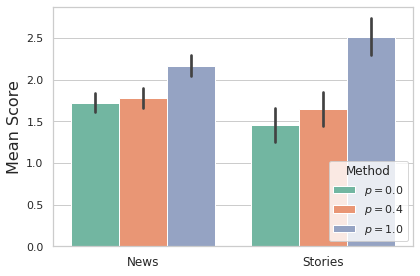

In [48]:
filtered_df = full_df[
                      (full_df["model"]=="gpt2-xl") & 
                      (full_df["dataset"]=="Short Stories") | (full_df["dataset"]=="New York Times") &
                      (full_df["dec_strat_value"] != -1)]
filtered_df = copy.deepcopy(filtered_df)
filtered_df["dataset"] = filtered_df["dataset"].apply(map_playlist_name)
filtered_df["dec_strat_value"] = filtered_df["dec_strat_value"].apply(map_p_value)
p = sns.barplot(x="dataset", y="points", hue="dec_strat_value", data=filtered_df, hue_order=["$p=0.0$","$p=0.4$","$p=1.0$"])
# p.set_title("Comparison of Generation Performance of GPT2-XL across values of top-p")
p.set_xlabel("", fontsize = 16)
p.set_ylabel("Mean Score", fontsize = 16)
p.legend(loc="lower right").set_title("Method")
matplotlib.rc('xtick', labelsize=12) 
plt.tight_layout()
plt.savefig("topp.pdf")

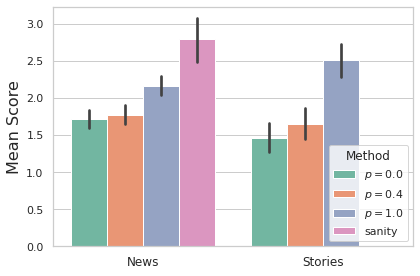

In [49]:
filtered_df = full_df[((full_df["model"]=="gpt2-xl") & (full_df["dataset"]=="Short Stories")) | (full_df["dataset"]=="New York Times")]
filtered_df = copy.deepcopy(filtered_df)
filtered_df["dataset"] = filtered_df["dataset"].apply(map_playlist_name)
filtered_df["dec_strat_value"] = filtered_df["dec_strat_value"].apply(map_p_value)

order = ["$p=0.0$","$p=0.4$","$p=1.0$", "sanity"]
p = plt.figure(figsize=[6, 4]).subplots(1, 1)
p = sns.barplot(x="dataset", y="points", hue="dec_strat_value", data=filtered_df, hue_order=order, ax=p, )
p.set_xlabel("", fontsize=16)
p.set_ylabel("Mean Score", fontsize = 16)
p.legend(loc="lower right").set_title("Method")
matplotlib.rc('xtick', labelsize=12) 

plt.tight_layout()
plt.savefig("topp_with_baseline.pdf")

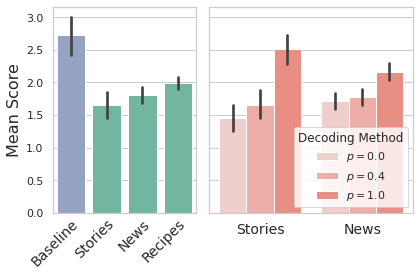

In [84]:
figure = plt.figure(figsize=[6, 4], tight_layout=True)
axes = figure.subplots(1, 2, sharey=True, gridspec_kw={'width_ratios': [0.7, 1]})
matplotlib.rc('xtick', labelsize=12) 

filtered_df = full_df[((full_df["model"]=="gpt2-xl") & (full_df["dec_strat_value"]==0.4)) | (full_df["model"]=="easy")]
filtered_df = copy.deepcopy(filtered_df)
filtered_df["dec_strat_value"] = filtered_df["dec_strat_value"].apply(map_p_value)
filtered_df["dataset"] = filtered_df["dataset"].apply(map_playlist_name)
filtered_df["dataset"] = filtered_df.apply(lambda x: "Baseline" if x["model"] == "easy" else x["dataset"], axis=1)

#palette=sns.color_palette("Set2")[:1]
palette1 = [sns.color_palette("Set2")[2]] + [sns.color_palette("Set2")[0]]*3
order = ["Baseline", "Stories", "News", "Recipes"]
# p = sns.barplot(x="dataset", y="points", data=filtered_df, order=["News", "Stories", "Recipes"])
ax = sns.barplot(x="dataset", y="points", data=filtered_df, order=order, ax=axes[0], palette=palette1)
ax.set_title("")
ax.set_xlabel("")
ax.tick_params(axis='x', which='major', pad=-2)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylabel("Mean Score", fontsize = 16)
# plt.savefig("genre.pdf")

palette = sns.light_palette("Salmon", n_colors=4)[1:4] + [sns.color_palette("Set2")[2]]

filtered_df = full_df[(full_df["model"]=="gpt2-xl") & 
                      (full_df["dataset"]=="Short Stories") | (full_df["dataset"]=="New York Times")]
filtered_df = copy.deepcopy(filtered_df)
filtered_df["dataset"] = filtered_df["dataset"].apply(map_playlist_name)
filtered_df["dec_strat_value"] = filtered_df["dec_strat_value"].apply(map_p_value)

order = ["$p=0.0$","$p=0.4$","$p=1.0$"]
ax = sns.barplot(x="dataset", y="points", hue="dec_strat_value", order=["Stories", "News"], data=filtered_df, hue_order=order, ax=axes[1], palette=palette)
ax.set_xlabel("", fontsize = 16)
ax.set_ylabel("")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=0)
# ax.legend(loc="upper left", bbox_to_anchor=(-.3, 1)).set_title("Decoding Method")
ax.legend(loc="lower right", ncol=1).set_title("Decoding Method")
plt.tight_layout()
plt.savefig("domain_topp.pdf", dpi=1000)

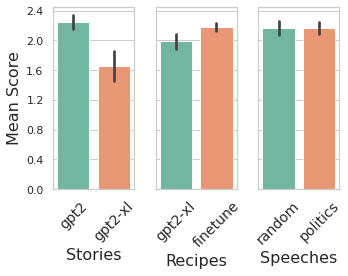

In [88]:
fig = plt.figure(figsize=[5, 4])
axes = fig.subplots(1, 3, sharey=True)
# plt.rcParams["figure.autolayout"] = True
matplotlib.rc('xtick', labelsize=14) 



filtered_df = full_df[(full_df["dataset"]=="Short Stories") & 
                                     (full_df["dec_strat_value"]==0.4) & 
                                     (full_df["model"]!="davinci") & (full_df["model"] != "human")]
filtered_df = copy.deepcopy(filtered_df)
filtered_df['to_plot'] = filtered_df['model'].apply(lambda x: 'gpt2' if x == 'gpt2' else x)
p = sns.barplot(x="to_plot", y="points", data=filtered_df, ax=axes[0])
p.set_title("")
p.set_xlabel("Stories", fontsize=16)
p.set_ylabel("Mean Score", fontsize=16)
p.set_yticks(np.arange(0, 2.6, 0.4))
#p.tick_params(axis='x', which='major', pad=-2)
p.set_xticklabels(p.get_xticklabels(), rotation=45)#, ha="right", rotation_mode="anchor")
                  
filtered_df = full_df[(full_df["dataset"]=="Recipes") & (full_df["model"]!="human")]
filtered_df = copy.deepcopy(filtered_df)
filtered_df['to_plot'] = filtered_df['model'].apply(lambda x: 'finetune' if x == 'finetuned' else 'gpt2-xl')
p = sns.barplot(x="to_plot", y="points", data=filtered_df, ax=axes[1], order=["gpt2-xl", "finetune"])
p.set_title("")
p.set_xlabel("Recipes", fontsize=16)
#p.tick_params(axis='x', which='major', pad=-2)
p.set_xticklabels(p.get_xticklabels(), rotation=45)#, ha="right", rotation_mode="anchor")
p.set_ylabel("")

filtered_df = full_df[(full_df["dataset"]=="Presidential Speeches") & (full_df["model"]!="human")]
filtered_df = copy.deepcopy(filtered_df)
filtered_df['to_plot'] = filtered_df['model'].apply(lambda x: 'random' if x == 'ctrl-nocode' else 'politics')
p = sns.barplot(x="to_plot", y="points", data=filtered_df, ax=axes[2])
p.set_title("")
p.set_xlabel("Speeches", fontsize=16)
#p.tick_params(axis='x', which='major', pad=-2)
p.set_xticklabels(p.get_xticklabels(), rotation=45)#, ha="right", rotation_mode="anchor")

p.set_ylabel("")

plt.tight_layout()
plt.savefig("model_size_and_finetuning.pdf")
plt.show()

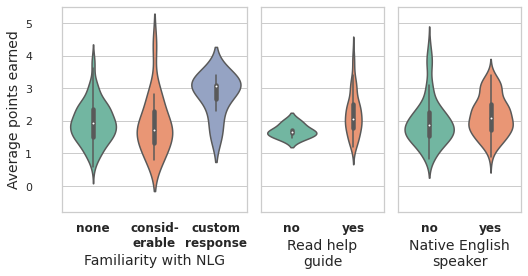

In [52]:
SHOW_FAMILIARTIES = False

if SHOW_FAMILIARTIES:
  fig = plt.figure(figsize=[15, 4])
  fig.tight_layout(pad=0)
  width_ratios = [0.1, 3, 2, 2, 2, 2, 2]
  axes = fig.subplots(1, len(width_ratios), sharey=True, gridspec_kw={'width_ratios': width_ratios})
else:
  fig = plt.figure(figsize=[7.5, 4])
  fig.tight_layout(pad=0)
  width_ratios = [0.1, 3, 2, 2]
  axes = fig.subplots(1, len(width_ratios), sharey=True, gridspec_kw={'width_ratios': width_ratios})

ax = axes[0]
ax.set_ylim([-0.8, 5.5])
ax.set_ylabel("Average points earned", fontsize=14)
ax.grid(visible=False)
ax.xaxis.set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.subplots_adjust(wspace=0)

# Familiarity
order = collections.OrderedDict([(1, "none"), (4, "consid-\nerable"), (-1, "custom\nresponse")])
df=full_df_freq10.groupby(["username", "gen_familiarity"]).points.mean().reset_index()
df = df[(df["gen_familiarity"] == -1) | (df["gen_familiarity"] == 1) | (df["gen_familiarity"] == 4)]
df["gen_familiarity"] = df["gen_familiarity"].apply(lambda x: order[x])
ax = sns.violinplot(x="gen_familiarity", y="points", data=df, order=order.values(), ax=axes[1])
ax.set_xticklabels(order.values(), fontsize=12, fontweight='bold', rotation=0)
ax.set_ylabel("")
ax.set_xlabel("Familiarity with NLG", fontsize=14)

# Read guide
order = collections.OrderedDict([("No", "no"), ("Yes", "yes")])
df = full_df_freq20[full_df_freq20["read_guide"] != ""]
df=df.groupby(["username", "read_guide"]).points.mean().reset_index()
df["read_guide"] = df["read_guide"].apply(lambda x: order[x])
ax = sns.violinplot(x="read_guide", y="points", data=df, order=order.values(), ax=axes[2])
ax.set_xticklabels(order.values(), fontsize=12, fontweight='bold')
ax.set_ylabel("")
ax.set_xlabel("Read help\nguide", fontsize=14)

# Native English speaker
df = full_df_freq20[full_df_freq20["english"] != ""]
df=df.groupby(["username", "english"]).points.mean().reset_index()
ax = sns.violinplot(x="english", y="points", data=df, ax=axes[3])
ax.set_xticklabels(order.values(), fontsize=12, fontweight='bold')
ax.set_ylabel("")
ax.set_xlabel("Native English\nspeaker", fontsize=14)

if SHOW_FAMILIARTIES:
  # Recipe familiarity
  order = [1, 5]
  df = full_df_freq20[(full_df_freq20["recipe_familiarity"] == 1) | (full_df_freq20["recipe_familiarity"] == 5)]
  df = df[df['dataset']=="Recipes"].groupby(["username", "recipe_familiarity"]).points.mean().reset_index()
  ax = sns.violinplot(x="recipe_familiarity", y="points", data=df, ax=axes[4])
  ax.set_xticklabels(order, fontsize=12, fontweight='bold')
  ax.set_ylabel("")
  ax.set_xlabel("Familiarity with\nrecipes", fontsize=14)

  # News familiarity
  order = [1, 5]
  df = full_df_freq20[(full_df_freq20["news_familiarity"] == 1) | (full_df_freq20["news_familiarity"] == 5)]
  df = df[df['dataset']=="Recipes"].groupby(["username", "news_familiarity"]).points.mean().reset_index()
  ax = sns.violinplot(x="news_familiarity", y="points", data=df, ax=axes[5])
  ax.set_xticklabels(order, fontsize=12, fontweight='bold')
  ax.set_ylabel("")
  ax.set_xlabel("Familiarity with\nnews", fontsize=14)

  # Fiction familiarity
  order = [1, 5]
  df = full_df_freq20[(full_df_freq20["stories_familiarity"] == 1) | (full_df_freq20["stories_familiarity"] == 5)]
  df = df[df['dataset']=="Recipes"].groupby(["username", "stories_familiarity"]).points.mean().reset_index()
  ax = sns.violinplot(x="stories_familiarity", y="points", data=df, ax=axes[6])
  ax.set_xticklabels(order, fontsize=12, fontweight='bold')
  ax.set_ylabel("")
  ax.set_xlabel("Familiarity with\nfiction", fontsize=14)
plt.tight_layout()
plt.savefig("survey_results_no_fam.pdf")
plt.show()

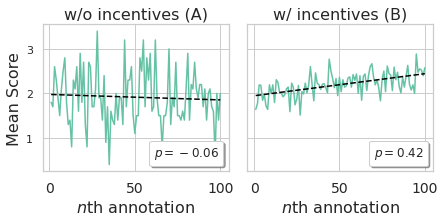

In [145]:
def analyze_progress(df, k=50):
  """Analyze whether annotators improve in aggregate over k annotations."""
  all_score_series = []
  annotators = df[df["pk"] > k].reset_index()["annotator"].tolist()
  for annotator in annotators:
    annotations = full_df[full_df["annotator"] == annotator]
    score_series = annotations.sort_values("date")["points"][:k].tolist()
    all_score_series.append(score_series)

  return np.array(all_score_series), len(annotators)

fig = plt.figure(figsize=[7, 3])
axes = fig.subplots(1, 2, sharey=True)
s1, n1 = analyze_progress(full_df[(full_df['date'] < '2021-10-1')].groupby('annotator').count(), 100)
s2, n2 = analyze_progress(full_df[(full_df['date'] > '2021-10-1')].groupby('annotator').count(), 100)

a, b = np.polyfit(range(1, 100+1), np.mean(np.array(s1), axis=0), 1)
axes[0].plot(range(1, 100+1), np.mean(np.array(s1), axis=0))
axes[0].plot(range(1, 100+1), a*range(1, 100+1)+b, color='black', linestyle='--')
axes[0].legend(loc="lower right", title="$p=-0.06$", shadow=True, labelspacing=0)

a, b = np.polyfit(range(1, 100+1), np.mean(np.array(s2), axis=0), 1)
axes[1].plot(range(1, 100+1), np.mean(np.array(s2), axis=0))
axes[1].plot(range(1, 100+1), a*range(1, 100+1)+b, color='black', linestyle='--')
axes[1].legend(loc="lower right", title="$p=0.42$", shadow=True, labelspacing=0)
axes[0].set_title("w/o incentives (A)", fontsize = 16)
# axes[0].set(xlabel="$n$th annotation", ylabel="Mean score", titlesize=16)
axes[0].set_xlabel("$n$th annotation", fontsize = 16)
axes[0].set_ylabel("Mean Score", fontsize = 16)
axes[1].set_title("w/ incentives (B)",  fontsize = 16)
axes[1].set_xlabel("$n$th annotation", fontsize = 16)
plt.subplots_adjust(wspace=0.1)
plt.subplots_adjust(bottom=0.2)
plt.savefig("overtime.pdf")
plt.show()

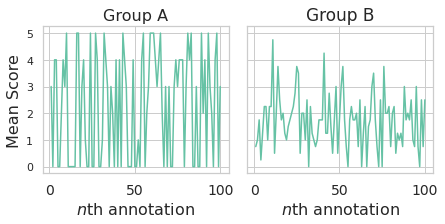

In [132]:
def analyze_progress(df, k=50):
  """Analyze whether annotators improve in aggregate over k annotations."""
  all_score_series = []
  annotators = df[df["pk"] > k].reset_index()["annotator"].tolist()
  for annotator in annotators:
    annotations = full_df[full_df["annotator"] == annotator]
    score_series = annotations.sort_values("date")["points"][:k].tolist()
    all_score_series.append(score_series)

  return np.array(all_score_series), len(annotators)

fig = plt.figure(figsize=[7, 3])
axes = fig.subplots(1, 2, sharey=True)
filtered_df = full_df[(full_df["dataset"] == 'New York Times')]
k=100
s1, n1 = analyze_progress(filtered_df[(filtered_df['date'] < '2021-10-1')].groupby('annotator').count(), k)
s2, n2 = analyze_progress(filtered_df[(filtered_df['date'] > '2021-10-1')].groupby('annotator').count(), k)

axes[0].plot(range(1, k+1), np.mean(np.array(s1), axis=0))
axes[1].plot(range(1, k+1), np.mean(np.array(s2), axis=0))
axes[0].set_title("Group A", fontsize = 16)
# axes[0].set(xlabel="$n$th annotation", ylabel="Mean score", titlesize=16)
axes[0].set_xlabel("$n$th annotation", fontsize = 16)
axes[0].set_ylabel("Mean Score", fontsize = 16)
axes[1].set_title("Group B",  fontsize = 17)
axes[1].set_xlabel("$n$th annotation", fontsize = 16)
plt.subplots_adjust(wspace=0.1)
plt.subplots_adjust(bottom=0.2)
plt.savefig("overtime.pdf")
plt.show()

[4610, 2055, 2056, 4618, 2577, 4627, 5141, 4630, 2584, 2590, 4641, 5400, 5157, 5158, 5160, 2089, 5165, 4661, 4662, 5174, 2617, 5178, 2109, 2110, 4678, 2125, 5204, 2649, 4710, 2664, 4713, 2669, 4729, 2171, 2683, 1661, 2174, 5253, 13448, 2700, 2201, 4761, 2209, 1699, 5293, 4786, 1719, 1734, 2247, 4810, 4811, 2764, 2255, 1747, 2261, 4828, 4829, 2271, 5345, 5349, 1766, 4328, 4331, 5357, 1775, 1776, 4336, 2290, 1784, 5368, 4346, 1788, 5375, 1792, 5377, 1797, 1800, 4361, 1802, 4363, 4364, 1806, 1807, 4365, 4368, 1815, 1818, 4884, 1820, 2332, 1822, 2845, 4383, 4889, 4896, 5409, 4388, 5411, 4392, 5417, 5418, 1836, 4397, 1838, 1844, 5428, 1849, 4410, 14138, 4415, 1856, 2884, 4420, 4934, 2887, 4940, 2381, 4433, 1878, 2390, 4440, 4950, 4444, 4446, 4453, 1894, 4968, 5478, 5483, 5486, 4464, 4976, 2418, 4467, 2932, 4981, 4982, 4472, 4474, 5499, 5505, 1922, 5506, 1924, 1931, 1934, 5006, 1940, 1944, 1949, 5021, 1953, 4514, 4513, 5540, 1962, 1966, 1967, 1972, 2484, 1974, 2486, 5560, 5049, 1985, 4547, 4

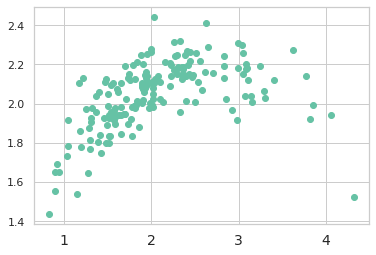


1.8458925514752458


<ipython-input-54-212cf0b937ce>:22: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  df_scores.hist(column=["Mean Score", "Standard Deviation"], ax=axes, sharey="True")


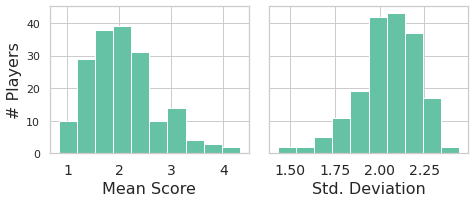

In [54]:
freq20_annotators = find_frequent_annotators(full_df, 20)
print(freq20_annotators)
full_df_freq20 = full_df[full_df["annotator"].isin(freq20_annotators)]

df_meanscore=full_df_freq20.groupby(["annotator"]).points.mean().reset_index()
df_meanscore.rename({"points": "Mean Score"}, axis=1, inplace=True)
df_stdscore=full_df_freq20.groupby(["annotator"]).points.std().reset_index()
df_stdscore.rename({"points": "Standard Deviation"}, axis=1, inplace=True)
df_scores = pd.merge(df_meanscore, df_stdscore, on="annotator")

print(df_scores.describe(percentiles=[.05,.5,.95]))
print("Correlation between mean score and std. dev " + str(df_scores["Mean Score"].corr(df_scores["Standard Deviation"])))
print("Std. dev for score over 3.8 " + str(df_scores[df_scores["Mean Score"] > 3.8]["Standard Deviation"].mean()))
plt.scatter(df_scores['Mean Score'], df_scores['Standard Deviation'])
plt.show()

print()
print(df_scores[df_scores["Mean Score"] > 3.8]["Standard Deviation"].mean())

fig = plt.figure(figsize=[7.5, 3])
axes = fig.subplots(1, 2, sharey=True)
df_scores.hist(column=["Mean Score", "Standard Deviation"], ax=axes, sharey="True")
axes[0].set(title='')
axes[1].set(title='')
axes[0].set_ylabel("# Players", fontsize = 16)
#axes[0].set(ylabel='# Annotators')
axes[0].set_xlabel("Mean Score", fontsize = 16)
axes[1].set_xlabel("Std. Deviation", fontsize = 16)
axes[1].xaxis.set_ticks(np.arange(1.5, 2.5, 0.25))

#axes[1].set(xlabel="Variance")
plt.subplots_adjust(wspace=0.1)
plt.subplots_adjust(bottom=0.2)
plt.savefig("mean_variance.pdf")
plt.show()

# Analysis of Annotations

### Correlations with other possible metrics

In [55]:
df = copy.deepcopy(full_df)

def foo(row):
  import pdb; pdb.set_trace()
  return row

df["correctly_after_boundary"] = df.predicted_boundary_index >= df.true_boundary_index
df["perfect"] = df.predicted_boundary_index == df.true_boundary_index
df["distance"] = df.apply(lambda row: np.max(row["predicted_boundary_index"] - row["true_boundary_index"], 0), axis=1)

df = df.groupby(["username"]).mean().reset_index()

for metric in ["correctly_after_boundary", "perfect", "distance"]:
  spearman = scipystats.spearmanr(df[metric], df["points"])
  pearson = scipystats.pearsonr(df[metric], df["points"])

  print("spearmanr for %s: %.2f, %f" % (metric, spearman[0], spearman[1]))
  print("pearsonr for %s: %.2f, %f\n" % (metric, pearson[0], pearson[1]))


spearmanr for correctly_after_boundary: 0.75, 0.000000
pearsonr for correctly_after_boundary: 0.77, 0.000000

spearmanr for perfect: 0.89, 0.000000
pearsonr for perfect: 0.90, 0.000000

spearmanr for distance: 0.32, 0.000000
pearsonr for distance: 0.36, 0.000000



### Correlations with sentence statistics

* Sentence length / relative sentence length
* Frequency of new noun phrases
* Fraction of various parts of speech
* Number of new named entities
* Likelihood
* Number of stop words

In [56]:
!python -m spacy download en_core_web_lg

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2022-12-09 17:21:46.095767: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 14 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [57]:
import spacy

nlp = spacy.load("en_core_web_lg")

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [58]:
cache = {}

In [59]:
def aggregate(data):
  if data.name == "predicted_boundary_index":
    return collections.Counter(list(data))
  else:
    compressed = list(set(data))
    if len(compressed) == 1:
      return compressed[0]

def is_descriptive(x):
  return x.pos_ in ["ADJ", "ADV"]

def is_noun(x):
  return x.pos_ in ["PRON", "PROPN", "NOUN"]

In [60]:
all_stats = []
for dataset in set(full_df["dataset"].tolist()) - {"Recipes"}:
  print(dataset)
  df = full_df[full_df["dataset"]==dataset].groupby("generation").agg(aggregate)
  df = df.reset_index()
  
  bad = 0
  for idx, row in df.filter(items=["true_boundary_index", "predicted_boundary_index", "prompt_body", "gen_body"]).iterrows():
    prompt = row["prompt_body"]
    gen = row["gen_body"]

    assert isinstance(prompt, str)
    assert isinstance(gen, str)

    prompt = prompt.split("_SEP_")
    gen = gen.split("_SEP_") if gen else []

    all_sentences = prompt + gen[:(10 - len(prompt))]

    if len(all_sentences) != 10:
      bad += 1
      continue

    first_gen_idx = len(prompt)

    predicted_indexes = {k+1:count for k, count in row["predicted_boundary_index"].items()}

    for s in all_sentences:
      if s not in cache:
        cache[s] = nlp(s)

    all_sentences = [cache[s] for s in all_sentences]

    ents_seen_so_far = set([e.text.lower() for e in all_sentences[0].ents])
    words_seen_so_far = set(w.text.lower() for w in all_sentences[0])

    num_stop_words = []
    for sdx in range(1, len(all_sentences)):
      sentence = all_sentences[sdx]

      ents = set(sentence.ents)
      num_non_new_ents = sum(e.text.lower() in ents_seen_so_far for e in ents)
      num_new_ents = sum(e.text.lower() not in ents_seen_so_far for e in ents)

      num_non_new_words = sum(w.text.lower() in words_seen_so_far for w in sentence)
      num_new_words = sum(w.text.lower() not in words_seen_so_far for w in sentence)

      ents_seen_so_far.update(e.text.lower() for e in ents)
      words_seen_so_far.update(w.text.lower() for w in sentence)

      num_stop_words = sum(w.text in spacy.lang.en.stop_words.STOP_WORDS for w in sentence)

      predictions_on_sentence = predicted_indexes.get(sdx, 0) / sum(predicted_indexes.values())

      num_nouns = sum(is_noun(x) for x in sentence)
      num_descriptive = sum(is_descriptive(x) for x in sentence)

      stats = {
          "len": len(sentence),
          "ratio_of_len_to_previous": len(sentence) / len(all_sentences[sdx-1]),
          "ratio_of_len_to_mean_previous": len(sentence) / np.mean([len(s) for s in all_sentences[:(sdx)]]),
          "num_new_ents": num_new_ents,
          "num_ents_total": len(ents),
          "fraction_new_ents": num_new_ents / len(sentence),
          "fraction_ents": len(ents) / len(sentence),
          "num_new_words": num_new_words,
          "fraction_new_words": num_new_words / len(sentence),
          "num_stop_words": len(sentence) - num_stop_words,
          "num_non_stop_words": num_stop_words,
          "fraction_stop_words": num_stop_words / len(sentence),
          "fraction_non_stop_words": 1 - (num_stop_words / len(sentence)),
          "fraction_preds_on_sentence": predictions_on_sentence,
          "fraction_nouns": num_nouns / len(sentence),
          "fraction_descriptive": num_descriptive / len(sentence),
          "was_picked_by_annotator": predicted_indexes.get(sdx, 0) > 0,
          "is_true_boundary": sdx == first_gen_idx,
          "is_generated": sdx >= first_gen_idx,
          "dataset": dataset,
      }

    all_stats.append(stats)
  print("Number bad:", bad)

New York Times


/usr/local/lib/python3.8/dist-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)


KeyboardInterrupt: ignored

In [ ]:
# import pickle as pkl
# with open("spacy_dump.pkl", "wb") as f:
#   pkl.dump(cache, f)

In [ ]:
def name_mapping(x):
  mapping = {
    "fraction_new_words": "new word",
    "fraction_non_stop_words": "not stopword",
    "fraction_nouns": "noun/pronoun",
    "fraction_descriptive": "adj/adv",
    "ratio_of_len_to_previous": "len / len prev",
    "ratio_of_len_to_mean_previous": "len / len\nall previous",
    "fraction_ents": "num ents / len",
    "fraction_new_ents": "num new ents / len",
    "num_ents_total": "named entity",
    "num_new_ents": "novel named entity",
    True: "yes",
    False: "no",
  }
  return mapping.get(x, x)
# for metric in ["len", "ratio_of_len_to_previous", "ratio_of_len_to_mean_previous", "num_new_ents", "num_ents_total", "num_stop_words", "fraction_stop_words"]:
# for metric in ["ratio_of_len_to_previous", "ratio_of_len_to_mean_previous", "num_new_ents", "num_ents_total", "fraction_stop_words"]:
# for metric in ["fraction_nouns", "fraction_descriptive"]:
# for metric in ["fraction_new_ents", "fraction_ents"]:

def gen_df_with_metrics(metrics, dataset):
  all_stats_rejigged = []
  for row in all_stats:
    if row["dataset"] == dataset:
      for metric in metrics:
        new_row = {
          "fraction_preds_on_sentence": row["fraction_preds_on_sentence"],
          "was_picked_by_annotator": name_mapping(row["was_picked_by_annotator"]),
          "is_true_boundary": name_mapping(row["is_true_boundary"]),
          "is_generated": name_mapping(row["is_generated"]),
          "metric": name_mapping(metric),
          "value": row[metric],
        }
        all_stats_rejigged.append(new_row)
  df = pd.DataFrame(all_stats_rejigged)
  return df

def gen_compressed_df_with_metrics(metrics, dataset):
  all_stats_rejigged = []
  for row in all_stats:
    if row["dataset"] == dataset:
      for metric in metrics:
        datapoint = {
          "metric": name_mapping(metric),
          "value": row[metric],
        }
        dp1 = copy.deepcopy(datapoint)
        if row["was_picked_by_annotator"]:
          dp1["type"] = "Selected by ≥1 players"
        else:
          dp1["type"] = "Never selected by player"
        
        dp2 = copy.deepcopy(datapoint)
        if row["is_generated"]:
          dp2["type"] = "Machine-generated"
        else:
          dp2["type"] = "Human-written"        

        all_stats_rejigged.extend([dp1, dp2])
  hue_order = ["Human-written", "Machine-generated", "Never selected by player", "Selected by ≥1 players"]
  df = pd.DataFrame(all_stats_rejigged)
  return df, hue_order

In [ ]:
# df = gen_df_with_metrics(["len", "num_new_words", "num_non_stop_words"])

def make_word_based_plot(ax, letter, dataset, legend=True):
  palette = sns.light_palette("Salmon", n_colors=3)[1:3] + sns.light_palette("DodgerBlue", n_colors=3)[1:3]


  # metrics = ["ratio_of_len_to_previous", "ratio_of_len_to_mean_previous", "
  metrics = ["num_ents_total", "num_new_ents"]
  df, hue_order = gen_compressed_df_with_metrics(metrics, dataset)

  ax = sns.barplot(x="metric", y="value", hue="type", hue_order=hue_order, palette=palette, data=df, ax=ax)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=12)
  ax.set_ylabel("")
  # ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: "%2.0f%%" % (y * 100)))
  if legend:
    ax.legend(title="In sentences that were:", loc="upper right")
  else:
    ax.get_legend().remove()
  ax.set_title("({}) {}".format(letter, map_playlist_name(dataset)), y=1.01, fontsize=14)
  ax.set_xlabel("")

figure = plt.figure(figsize=[12, 3.5], tight_layout=True)
axes = figure.subplots(1, 3, sharey=True)
make_word_based_plot(axes[0], "a", "New York Times", legend=False)
make_word_based_plot(axes[1], "b", "Presidential Speeches", legend=False)
make_word_based_plot(axes[2], "c", "Short Stories", legend=True)
axes[0].set_ylabel("Average # Occurences")
plt.tight_layout()
plt.savefig("ner_stats.pdf")
plt.show()

### Mean points per playlist

In [ ]:
def analyze_per_playlist():
  info_to_return = []
  playlist_names = set(playlist_df["shortname"].tolist())
  model_names = set(full_df["model"].tolist())
  for playlist in playlist_names:
    for model in model_names:
      if 'ctrl' in model:
        model = 'ctrl'
        df = full_df[(full_df["dataset"]==playlist) & ((full_df["model"]=='ctrl-Politics') | (full_df["model"]=='ctrl-nocode'))]
      else:
        df = full_df[(full_df["dataset"]==playlist) & 
                            (full_df["model"]==model)]
      
      if len(df) > 0:
        info = {"playlist": playlist,
                "model": model,
                "mean score": np.mean(df["points"]),
                "median score": np.median(df["points"]),
                "95% conf intvl": mean_confidence_interval_me(df["points"]),
                # "std dev": np.std(df["points"]),
                # "fraction_nonzero": len(df[df["points"] > 0]) / len(df),
                "num_annotations": len(df)
        }
        info_to_return.append(info)
  return pd.DataFrame(info_to_return)

analyze_per_playlist()

In [ ]:
def analyze_per_decoding_strat():
  info_to_return = []
  playlist_names = set(playlist_df["shortname"].tolist())
  model_names = set(full_df["model"].tolist())
  model_names.remove('human')
  for playlist in playlist_names:
    for model in model_names:
      for top_p_value in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        df = full_df[(full_df["dec_strat_value"]==top_p_value) &
                  (full_df["dataset"]==playlist) &
                  (full_df["model"]==model)]

        if len(df) > 0:
          info = {"p-value": top_p_value,
                  "playlist": playlist,
                  "model": model,
                  "mean_score": np.mean(df["points"]),
                  "95% conf intvl": mean_confidence_interval_me(df["points"]),
                  "std_dev": np.std(df["points"]),
                  # "median_score": np.median(df["points"]),
                  # "fraction_nonzero": len(df[df["points"] > 0]) / len(df),
                  "num_annotations": len(df),
          }
          info_to_return.append(info)
  return pd.DataFrame(info_to_return)

per_p_df = analyze_per_decoding_strat()
per_p_df

In [ ]:
def analyze_per_generation_length():
  info_to_return = []
  playlist_names = set(playlist_df["shortname"].tolist())
  model_names = set(full_df["model"].tolist())
  model_names.remove('human')
  for gen_len in range(10):
    df = full_df[(full_df["true_boundary_index"]==gen_len)]

    if len(df) > 0:
      info = {"true_boundary_index": gen_len,
              "mean_score": np.mean(df["points"]),
              "std_dev": np.std(df["points"]),
              "95% conf intvl": mean_confidence_interval_me(df["points"]),
              "median_score": np.median(df["points"]),
              "fraction_nonzero": len(df[df["points"] > 0]) / len(df),
              "num_annotations": len(df),
      }
      info_to_return.append(info)
  return pd.DataFrame(info_to_return)

per_p_df = analyze_per_generation_length()
per_p_df

### Comparison of XL models across p-values for NYT and Reddit

**Conclusion**: Sampling from full distribution (p=1.0) has worse quality. Argmax sampling (with repetition penalty) seems to be consistently better for text quality -- this is consistent with Daphne's research.

In [ ]:
filtered_df = full_df[
                      (full_df["model"]=="gpt2-xl") & 
                      (full_df["dataset"]=="Short Stories") | (full_df["dataset"]=="New York Times") &
                      (full_df["dec_strat_value"] != -1)]

filtered_df["dec_strat_value"] = filtered_df["dec_strat_value"].apply(map_p_value)
p = sns.barplot(x="dataset", y="points", hue="dec_strat_value", data=filtered_df, hue_order=["$p=0.0$","$p=0.4$","$p=1.0$"])
# p.set_title("Comparison of Generation Performance of GPT2-XL across values of top-p")
p.set_xlabel("Dataset", fontsize = 16)
p.set_ylabel("Mean Score", fontsize = 16)
p.legend(loc="lower right").set_title("Method")
plt.tight_layout()
plt.savefig("topp.pdf")

### Comparison of GPT2-XL p=0.4 across reddit, nyt, and recipes

**Conclusion:** We see that Recipes are the most difficult, then NYT and short stories. This shows that generation systems struggle with structured text and are better at more open-ended generations (?). Also shows that domain knowledge is important. (although NYT being better than reddit is interesting).

In [ ]:
filtered_df = full_df[((full_df["model"]=="gpt2-xl")) & 
                                     (full_df["dec_strat_value"]==0.4)]

filtered_df["dec_strat_value"] = filtered_df["dec_strat_value"].apply(map_p_value)
filtered_df["dataset"] = filtered_df["dataset"].apply(map_playlist_name)

p = sns.barplot(x="dataset", y="points", data=filtered_df, order=["News", "Stories", "Recipes"])
p.set_title("")
p.set_xlabel("Dataset")
p.set_ylabel("Mean Score", fontsize = 16)
plt.savefig("genre.pdf")

### Comparison of Model Size across same dataset and p-value

**Conclusion**: Bigger Models are better (good sanity check, nice to know this is confirmed) -- don't use GPT3 here because we only have 89 annotations

In [ ]:
filtered_df = full_df[(full_df["dataset"]=="Short Stories") & 
                                     (full_df["dec_strat_value"]==0.4) & 
                                     (full_df["model"]!="davinci") & (full_df["model"] != "human")]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 3)
p = sns.barplot(x="model", y="points", data=filtered_df, ax=axes[0])
p.set_title("")
p.set_xlabel("Stories")
p.set_ylabel("Mean Score")

filtered_df = full_df[(full_df["dataset"]=="Recipes") & (full_df["model"]!="human")]
filtered_df['to_plot'] = filtered_df['model'].apply(lambda x: 'finetune' if x == 'finetuned' else 'gpt2-xl')
p = sns.barplot(x="to_plot", y="points", data=filtered_df, ax=axes[1])
p.set_title("")
p.set_xlabel("Recipes")
p.set_ylabel("")

filtered_df = full_df[(full_df["dataset"]=="Presidential Speeches") & (full_df["model"]!="human")]
filtered_df['to_plot'] = filtered_df['model'].apply(lambda x: 'ctrl' if x == 'ctrl-nocode' else 'ctrl-pol')
p = sns.barplot(x="to_plot", y="points", data=filtered_df, ax=axes[2])
p.set_title("")
p.set_xlabel("Speeches")
p.set_ylabel("")

plt.savefig("model_size_and_finetuning.pdf")
plt.show()

### Comparison of fine-tuning performance

In [ ]:
filtered_df = full_df[(full_df["dataset"]=="Recipes") & (full_df["model"]!="human")]

p = sns.barplot(x="model", y="points", data=filtered_df)
p.set_title("Comparison of Generation Performance of Fine-tuning on Recipes")
p.set_xlabel("Model", fontsize = 16)
p.set_ylabel("Mean Score", fontsize = 16)

In [ ]:
filtered_df = full_df[(full_df["dataset"]=="Presidential Speeches") & (full_df["model"]!="human")]

p = sns.barplot(x="model", y="points", data=filtered_df)
p.set_title("Comparison of Generation Performance of CTRL control codes")
p.set_xlabel("Model", fontsize = 16)
p.set_ylabel("Mean Score", fontsize = 16)

###Mean Points for users that have no familiarity with generated text vs. users that do

In [ ]:
df_familiarity=full_df_freq10.groupby(["username", "gen_familiarity"]).points.mean().reset_index()
df_familiarity.rename({"gen_familiarity": "Familiarity with NLG", "points": "Avg points earned"}, axis=1, inplace=True)
sns.violinplot(x="Familiarity with NLG", y="Avg points earned", data=df_familiarity)
plt.ylim([-0.6, 5.5])

### Mean Points for native vs. non-native English speakers

In [ ]:
df_language=full_df_freq10.groupby(["username", "english"]).points.mean().reset_index()
df_language.rename({"english": "Native English speaker", "points": "Avg points earned"}, axis=1, inplace=True)
sns.violinplot(x="Native English speaker", y="Avg points earned", data=df_language)
plt.ylim([-0.6, 5.5])

###Mean points for users with familiarity in a given domain

In [ ]:
df_familiarity=full_df_freq20[full_df_freq20['dataset']=="Recipes"].groupby(["username", "recipe_familiarity"]).points.mean().reset_index()
df_familiarity.rename({"recipe_familiarity": "Familiarity with Recipes", "points": "Avg points earned"}, axis=1, inplace=True)
sns.violinplot(x="Familiarity with Recipes", y="Avg points earned", data=df_familiarity)
plt.ylim([-0.6, 5.5])

In [ ]:
df_familiarity=full_df_freq20[full_df_freq20['dataset']=="Short Stories"].groupby(["username", "stories_familiarity"]).points.mean().reset_index()
df_familiarity.rename({"stories_familiarity": "Familiarity with Short Stories", "points": "Avg points earned"}, axis=1, inplace=True)
sns.violinplot(x="Familiarity with Short Stories", y="Avg points earned", data=df_familiarity)
plt.ylim([-0.6, 5.5])

In [ ]:
df_familiarity=full_df_freq20[full_df_freq20['dataset']=="New York Times"].groupby(["username", "news_familiarity"]).points.mean().reset_index()
df_familiarity.rename({"news_familiarity": "Familiarity with News", "points": "Avg points earned"}, axis=1, inplace=True)
sns.violinplot(x="Familiarity with News", y="Avg points earned", data=df_familiarity)
plt.ylim([-0.6, 5.5])

### Mean points for CIS majors vs. non-CIS majors

In [ ]:
def is_cis_adjacent(x):
  cs_majors = ["CIS"]#, "MCIT", "CGGT", "CMPE", "ESE", "ROBO", "NETS", "DATS", "CBIO", "DMD", "SCMP"]
  return any([maj in list(x) for maj in cs_majors])
  
copied_df = full_df_freq20
copied_df['is_cis'] = full_df_freq20['major'].apply(is_cis_adjacent)
df_cis=copied_df.groupby(["username", "is_cis"]).points.mean().reset_index()
sns.violinplot(x="is_cis", y="points", data=df_cis)
plt.ylim([-0.6, 5.5])

### Mean points for those who read the guide and those who did not

In [ ]:
df_familiarity=full_df_freq20.groupby(["username", "read_guide"]).points.mean().reset_index()
df_familiarity.rename({"read_guide": "Read Guide", "points": "Avg points earned"}, axis=1, inplace=True)
sns.violinplot(x="Read Guide", y="Avg points earned", data=df_familiarity, order=["No", "Yes"])
plt.ylim([-0.6, 5.5])

## Reasoning behind annotation

We see that conditioning on grammar or generic-ness is least predictive. It's better to look for common sense, contradictions, or irrelevance. 

We also see that irrelevant makes up a very large percentage of all reported errors, suggesting that irrelevant generations are the biggest factor being picked up on by human annotators.

In [ ]:
REASONS = ["grammar", "repetition", "irrelevant", "contradicts_sentence", "contradicts_knowledge", "common_sense", "coreference", "generic", "other"]

def is_reason(x, reason):
  return reason in list(x)
def is_other(x):
  return len(list(x)) != 0 and not any([r in list(x) for r in REASONS])

reason_df = copy.deepcopy(full_df)
#reason_df = reason_df[(reason_df["predicted_boundary_index"] >= reason_df["true_boundary_index"])]
for r in REASONS:
  reason_df[r] = full_df['reason'].apply(lambda x: is_reason(x, r))
reason_df["other"] = full_df['reason'].apply(is_other)

def analyze_per_reason():
  info_to_return = []
  for r in REASONS:
    df = reason_df[(reason_df[r]==True) & (reason_df["model"]!="easy") & (reason_df["model"]!="human") & (reason_df["model"]!="davinci")]
    
    if len(df) > 0:
      info = {"reason": r,
              "mean score": np.mean(df["points"]),
              "95% conf": mean_confidence_interval_me(df["points"]),
              #"median score": np.median(df["points"]),
              #"std dev": np.std(df["points"]), #TODO: switch to 95% confidence interval?
              #"fraction_nonzero": len(df[df["points"] > 0]) / len(df),
              "num_annotations": len(df)
      }
      info_to_return.append(info)
  return pd.DataFrame(info_to_return)

analyze_per_reason()

In [ ]:
def isin(x,y):
  return x in y

def print_random_example_reason(reason, df):
  filtered_df = df
  df["isreason"] = df["reason"].apply(lambda x: is_reason(x, reason))
  df = df[df["isreason"]==True]
  sampled = filtered_df.sample(n=1)
  sents = sampled['gen_body'].tolist()[0].split("_SEP_")
  for i, s in enumerate(sents):
    print(s)

print_random_example_reason("repetition", full_df)

In [ ]:
def analyze_per_reason_model():
  info_to_return = []
  for r in REASONS:
    for model in set(full_df["model"].tolist()):
      df = reason_df[(reason_df[r]==True) & (reason_df["model"]==model)]
    
      if len(df) > 0:
        info = {"reason": r,
                "model": model,
                "mean score": np.mean(df["points"]),
                "median score": np.median(df["points"]),
                "fraction_nonzero": len(df[df["points"] > 0]) / len(df),
                "num_annotations": len(df)
        }
        info_to_return.append(info)
  return pd.DataFrame(info_to_return)

analyze_per_reason_model()

# TODO: When people correctly gave the answer as machine generated (any sentence from machine)

# model_names = set(full_df["model"].tolist())
#   model_names.remove('human')
#   for playlist in playlist_names:
#     for model in model_names:
#       for top_p_value in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
#         df = full_df[(full_df["dec_strat_value"]==top_p_value) &
#                   (full_df["dataset"]==playlist) &
#                   (full_df["model"]==model)]

In [ ]:
def plot_boundary_distribution(dataset, ax, df, dataset_name, boundary_name):

  boundaries = df[df[dataset_name]==dataset][boundary_name].tolist()
  boundaries = collections.Counter(boundaries)

  if boundary_name == "num_sentences":
    data = [boundaries.get(i) for i in range(1,11)]
    labels = range(1,11)
  else:
    data = [boundaries.get(i) for i in range(10)]
    labels = range(10)

  ax.pie(data, labels=labels, autopct='%.0f%%')
  ax.set_title(map_playlist_name(dataset))



## Figure for reason analysis

In [ ]:
fig = plt.figure(figsize=[13, 3])
axes = fig.subplots(1, 5)

def plot_reasons_pie(df, ax, title):
  data = [df[r].sum() for r in REASONS]
  patches, texts, autotexts = ax.pie(data, autopct='%.0f%%', pctdistance=0.8, textprops={'fontsize': 11})
  ax.set_title(title, y=0.95, fontsize=14)
  return patches

plot_reasons_pie(reason_df[(reason_df['model']=='easy')], axes[0], "Baseline")
patches = plot_reasons_pie(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=="Short Stories") & (reason_df['model']=='gpt2-xl')], axes[1], "Stories")
plot_reasons_pie(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=='New York Times') & (reason_df['model']=='gpt2-xl')], axes[2], "News")
plot_reasons_pie(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=="Recipes") & (reason_df['model']=='gpt2-xl')], axes[3], "Recipes")
plot_reasons_pie(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=='Presidential Speeches') & (reason_df['model']=='ctrl-nocode')], axes[4], "Speeches")

fig.legend(patches, REASONS, loc="lower center", ncol=5, labelspacing=0.0, handletextpad=0.3, columnspacing=1, prop={'size':13})
plt.subplots_adjust(wspace=0)
plt.subplots_adjust(bottom=0.2)
axes[3].plot([1.35, 1.35], [-1, 1], color='black', lw=3, clip_on=False)
plt.tight_layout()
plt.savefig("reasons_per_domain.pdf")

In [ ]:

from matplotlib import pyplot as plt

plt.figure(figsize=(8, 8))

# plt.axes(rect, ...),
# where *rect* = [left, bottom, width, height] in normalized (0, 1) units
ax0 = plt.axes([0, 0, 1, 1])
ax0.set_xticks([])
ax0.set_yticks([])

ax1 = plt.axes([0.1, 0.6, 0.3, 0.3])

ax2 = plt.axes([0.6, 0.6, 0.3, 0.3])

ax3 = plt.axes([0.1, 0.1, 0.3, 0.3])

ax4 = plt.axes([0.6, 0.1, 0.3, 0.3])

ax0.plot([0.5, 0.5], [0, 1], color='lightgreen', lw=5)
ax0.plot([0, 1], [0.5, 0.5], color='lightgreen', lw=5)

plt.show()


In [ ]:
fig = plt.figure(figsize=[5, 5])
axes = fig.subplots(2, 2)
print(axes.flat)

def plot_reasons_pie(df, ax, title):
  data = [df[r].sum() for r in REASONS]
  patches, texts, autotexts = ax.pie(data, autopct='%.0f%%', pctdistance=0.8, textprops={'fontsize': 8})
  ax.set_title(title, y=0.95)
  return patches
  
patches = plot_reasons_pie(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=="Short Stories") & (reason_df['model']=='gpt2-xl')], axes[0,0], "Stories")
plot_reasons_pie(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=='New York Times') & (reason_df['model']=='gpt2-xl')], axes[0, 1], "News")
plot_reasons_pie(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=="Recipes") & (reason_df['model']=='gpt2-xl')], axes[1, 0], "Recipes")
plot_reasons_pie(reason_df[(reason_df['model']=='easy')], axes[1,1], "Baseline")

fig.legend(patches, REASONS, loc="lower center", ncol=5, prop={'size':7})
plt.savefig("reasons_per_domain_square.pdf")

### Alternate style figure

In [ ]:
import matplotlib.gridspec as gridspec

REASONS = ["grammar", "repetition", "irrelevant", "contradicts_sentence", "contradicts_knowledge", "common_sense", "coreference", "generic", "other"]

def plot_reasons_pie_triangle(df, ax, title):
  data = [df[r].sum() for r in REASONS]
  patches, texts, autotexts = ax.pie(data, autopct='%.0f%%', pctdistance=0.8, textprops={'fontsize': 9})
  ax.set_title(title, y=0.92)
  return patches

fig = plt.figure(figsize=[7, 6])
gs = gridspec.GridSpec(nrows=3, ncols=6, wspace=0, hspace=0, height_ratios=[1,0.4,1])
fig.legend(patches,REASONS, loc="lower center", ncol=4, prop={'size':10})

plot_reasons_pie_triangle(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=="Short Stories") & (reason_df['model']=='gpt2-xl')], fig.add_subplot(gs[:2, :2]), "Short Stories")
plot_reasons_pie_triangle(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=="Recipes") & (reason_df['model']=='gpt2-xl')], fig.add_subplot(gs[1:, 1:3]), "Recipes")
plot_reasons_pie_triangle(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=='New York Times') & (reason_df['model']=='gpt2-xl')], fig.add_subplot(gs[:2, 2:4]), "New York Times")
plot_reasons_pie_triangle(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=='Presidential Speeches') & (reason_df['model']=='ctrl-nocode')], fig.add_subplot(gs[1:, 3:5]), "Presidential Speeches")
plot_reasons_pie_triangle(reason_df[(reason_df['model']=='easy')], fig.add_subplot(gs[:2, 4:]), "Baseline")

plt.savefig("reasons_per_model_new.pdf")

In [ ]:
import matplotlib.gridspec as gridspec

REASONS = ["grammar", "repetition", "irrelevant", "contradicts_sentence", "contradicts_knowledge", "common_sense", "coreference", "generic", "other"]

def plot_reasons_pie_triangle(df, ax, title):
  data = [df[r].sum() for r in REASONS]
  patches, texts, autotexts = ax.pie(data, autopct='%.0f%%', pctdistance=0.8, textprops={'fontsize': 14})
  ax.set_title(title, fontsize=16, y=0.92)
  return patches

fig = plt.figure(figsize=[7, 6])
gs = gridspec.GridSpec(nrows=3, ncols=5, wspace=0, hspace=0, height_ratios=[1,0.6,1])
fig.legend(patches,REASONS, loc="lower center", ncol=4, prop={'size':10})

plot_reasons_pie_triangle(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=="Short Stories") & (reason_df['model']=='gpt2-xl')], fig.add_subplot(gs[:2, :2]), "Stories")
plot_reasons_pie_triangle(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=="Recipes") & (reason_df['model']=='gpt2-xl')], fig.add_subplot(gs[1:, 1:3]), "Recipes")
plot_reasons_pie_triangle(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=='New York Times') & (reason_df['model']=='gpt2-xl')], fig.add_subplot(gs[:2, 2:4]), "News")
plot_reasons_pie_triangle(reason_df[(reason_df['model']=='easy')], fig.add_subplot(gs[1:, 3:]), "Sanity")

plt.savefig("reasons_per_model_jagged.pdf")

In [ ]:
import matplotlib.gridspec as gridspec

REASONS = ["grammar", "repetition", "irrelevant", "contradicts_sentence", "contradicts_knowledge", "common_sense", "coreference", "generic", "other"]

def plot_reasons_pie_triangle(df, ax, title):
  data = [df[r].sum() for r in REASONS]
  patches, texts, autotexts = ax.pie(data, autopct='%.0f%%', pctdistance=0.8, textprops={'fontsize': 14})
  ax.set_title(title, fontsize=16, y=0.92)
  return patches

fig = plt.figure(figsize=[7, 6])
gs = gridspec.GridSpec(nrows=3, ncols=4, wspace=0, hspace=0, height_ratios=[1,0.3,1])
fig.legend(patches,REASONS, bbox_to_anchor=(0.5, -0.05), loc="lower center", ncol=4, prop={'size':10})

plot_reasons_pie_triangle(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=="Short Stories") & (reason_df['model']=='gpt2-xl')], fig.add_subplot(gs[:2, :2]), "Stories")
plot_reasons_pie_triangle(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=="Recipes") & (reason_df['model']=='gpt2-xl')], fig.add_subplot(gs[1:, 1:3]), "Recipes")
plot_reasons_pie_triangle(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=='New York Times') & (reason_df['model']=='gpt2-xl')], fig.add_subplot(gs[:2, 2:]), "News")

plt.savefig("reasons_per_model_triangle.pdf")

## Point Distributions

### Per playlist

In [ ]:
import collections

In [ ]:
df = full_df[full_df["model"].isin(('ctrl-Politics', 'ctrl-nocode', 'finetuned', 'gpt2-xl'))]
df = df[df["dec_strat_value"] == 0.4]

playlists = set(df["dataset"].tolist())
to_plot = []
for playlist in playlists:
  points = df[df["dataset"]==playlist].points.tolist()
  points = collections.Counter(points)

  heights = np.array(list(points.values())) / sum(points.values())
  for point_value, height in zip(points, heights):
    to_plot.append({"Points earned": point_value,
                    "Fraction of annotations":height,
                    "Domain": map_playlist_name(playlist)})

In [ ]:
to_plot = pd.DataFrame(to_plot)
sns.barplot(x="Points earned", y="Fraction of annotations", hue="Domain", data=to_plot)
save("point_distribution.pdf")

### Per annotator

In [ ]:
full_df.groupby('annotator').points.mean().plot.hist(
    title='Achieved Points Distribution'
)

## Find top annotators
These are annotators who got in the top quartile of annotators who did at least 10 annotations.

In [ ]:
def find_top_annotators(df, min_n=10):
  """Analyze whether annotators improve in aggregate over k annotations."""
  
  annotators_and_points = []

  for annotator in set(df["annotator"].tolist()):
    points = df[df["annotator"] == annotator]["points"].tolist()
    
    if len(points) >= min_n:
      annotators_and_points.append((annotator, np.mean(points)))

  df = pd.DataFrame(annotators_and_points, columns=["annotator", "points"])
  quintile = np.quantile(df.points.tolist(), 0.75)
  print(quintile)
  df = df[df["points"] >= quintile]
  print(len(df))

  return df
top_annotators_df = find_top_annotators(full_df, 1)

These are the annotators who did at least 50 annotations

In [ ]:
def find_frequent_annotators(df, min_count):  
  annotators_and_points = []

  for annotator in set(df["annotator"].tolist()):
    points = df[df["annotator"] == annotator]["points"].tolist()
    
    if len(points) >= 20:
      annotators_and_points.append((annotator, np.mean(points), len(points)))

  df = pd.DataFrame(annotators_and_points, columns=["annotator", "points", "count"])
  print(len(df))

  return df
freq20_annotators_df = find_frequent_annotators(full_df, 20)
freq50_annotators_df = find_frequent_annotators(full_df, 50)

## Find bad annotators

In [ ]:
full_df["predicted_boundary_index"]
full_df.groupby('annotator').sum()

In [ ]:
def find_problematic_annotators(df):
  """Analyze whether annotators improve in aggregate over k annotations."""
  
  too_many_same_df = []

  for annotator in set(df["annotator"].tolist()):
    guesses = df[df["annotator"] == annotator]["predicted_boundary_index"].tolist()
    
    # Check of they almost always guessed the same boundary
    modal_guess = scipy.stats.mode(guesses)
    fraction_modal = modal_guess.count[0] / len(guesses)
    if fraction_modal > 0.9:
      too_many_same_df.append((annotator, modal_guess, fraction_modal, len(guesses)))

  return pd.DataFrame(
      too_many_same_df, columns=["annotator", "guess", "fractional_model", "num_annotations"])
df = find_problematic_annotators(full_df)
df

## Annotator performance over time

Of the annotators who did at least K annotations, plot their mean score over time

In [ ]:
def analyze_progress(df, k=50):
  """Analyze whether annotators improve in aggregate over k annotations."""
  all_score_series = []
  annotators = df[df["pk"] > k].reset_index()["annotator"].tolist()
  print(annotators)
  for annotator in annotators:
    annotations = full_df[full_df["annotator"] == annotator]
    score_series = annotations.sort_values("date")["points"][:k].tolist()
    all_score_series.append(score_series)
  return np.array(all_score_series), len(annotators)

In [ ]:
def analyze_and_plot(s, n, k, title=''):
  print(n)
  data = np.array(s)
  data = np.mean(data, axis=0)
  print("spearmanr: %.2f, %f" % scipystats.spearmanr(range(k), data))
  print("pearsonr: %.2f, %f" % scipystats.pearsonr(range(k), data))
  plt.plot(range(1, k+1), data)
  plt.ylabel("Mean score")
  plt.xlabel("$n$th annotation")
  plt.title("Performance over time")
  if title:
    plt.savefig(title)
  plt.show()

### Analysis of annotators getting better over time (1st Batch)

**Conclusion**: We see no correlation on the first batch of annotators. They do not improve over time

In [ ]:
k = 50
s, n = analyze_progress(full_df[(full_df['date'] < '2021-10-1')].groupby('annotator').count(), k)
analyze_and_plot(s, n, k)

In [ ]:
k = 100
s, n = analyze_progress(full_df[(full_df['date'] < '2021-10-1')].groupby('annotator').count(), k)
analyze_and_plot(s, n, k, "overtimeb1.pdf")

In [ ]:
# s, n = analyze_progress(full_df[(full_df['date'] < '2021-10-1')].groupby('annotator').count(), k)
# analyze_and_plot(s, n, k, "overtimeb1.pdf")

### Analysis of annotators getting better over time (2nd Batch)

**Conclusion**: We actually see a positive correlation (over 0.3) for k=50, 100, and 200 on the second batch of annotators. They DO actually improve over time. This suggests that, with the correct instructions, annotators may be able to be taught how to improve at detecting generated text.

In [ ]:
k = 50
s, n = analyze_progress(full_df[(full_df['date'] > '2021-10-1')].groupby('annotator').count(), k)
analyze_and_plot(s, n, k)

In [ ]:
k = 100
s, n = analyze_progress(full_df[(full_df['date'] > '2021-10-1')].groupby('annotator').count(), k)
analyze_and_plot(s, n, k, "overtimeb2.pdf")

In [ ]:
k = 200
s, n = analyze_progress(full_df[(full_df['date'] > '2021-10-1')].groupby('annotator').count(), k)
analyze_and_plot(s, n, k)

## Inter-annotator agreement

### Difference in abilities

In [ ]:
def analyze_ability_differences(df, k=50):
  """Analyze whether annotators improve in aggregate over k annotations."""
  df = df.groupby('annotator').count()
  all_score_series = []
  annotators = df[df["pk"] >= k].reset_index()["annotator"].tolist()
  for annotator in annotators:
    annotations = full_df[full_df["annotator"] == annotator]
    score_series = annotations.sort_values("date")["points"][:k].tolist()
    all_score_series.append(score_series)
    
  return all_score_series

In [ ]:
scores = analyze_ability_differences(full_df, 50)
sum_scores = [sum(s) for s in scores]

In [ ]:
print("Mean score:", np.mean(sum_scores))
print("Std score:", np.std(sum_scores))

In [ ]:
df = full_df.groupby('annotator').count()
annotators = df[df["pk"] >= 50].reset_index()["annotator"].tolist()

df = full_df[full_df["annotator"].isin(annotators)]
df = df.groupby('annotator').sum()
# df = annotation_df.groupby('generation').boundary.apply(list).reset_index()
# df = df[df.apply(lambda row: len(row["boundary"]) >= 4, axis=1)]

### Fraction agreement
For every pair of annotators who annotated the same generaton, what fraction guessed the same boundary?

In [ ]:
annotations_per_gen = annotation_df.groupby('generation')
num_annotations_per_gen = annotations_per_gen.points.count()

In [ ]:
def analyze_fraction_agreements():
  generation_ids = set(full_df["generation"].tolist())
  annotations_per_gen = full_df.groupby('generation')

  overall_num_annotations = 0
  overall_num_agreements = 0

  x = annotations_per_gen.predicted_boundary_index.value_counts()
  for idx, generation in enumerate(generation_ids):
    chosen_boundaries = x[generation]
    chosen_boundaries = {k: chosen_boundaries[k] for k in chosen_boundaries.keys()}
    
    total_annotations = sum(chosen_boundaries.values())
    if total_annotations > 1:
      total_agreements = sum(v for v in chosen_boundaries.values() if v > 1)

      overall_num_annotations += total_annotations
      overall_num_agreements += total_agreements

  print("Out of {} total annotations on generations with >1 annotation, {} were in agreement with another annotation on the true boundary position. That is {}".format(
      overall_num_annotations, overall_num_agreements, overall_num_agreements/overall_num_annotations
  ))
analyze_fraction_agreements()

# TODO: Figure out what the baseline of random guessing would be,

### Krippendorf's Alpha

In [ ]:
import nltk.metrics

In [ ]:
from nltk.metrics.agreement import AnnotationTask

In [ ]:
# Get all game rounds for which there were 4 or more annotations.
df = full_df.groupby('generation').predicted_boundary_index.apply(list).reset_index()
df = df[df.apply(lambda row: len(row["predicted_boundary_index"]) >= 4, axis=1)]

In [ ]:
def build_annotation_task(df):
  annotation_data = []
  for idx, row in df.iterrows():
    coder = row["annotator"]
    item = row["generation"]
    label = row["predicted_boundary_index"]
    annotation_data.append((coder,item,label))
  ann_task = AnnotationTask(annotation_data)
  return ann_task

def build_binary_annotation_task(df):
  annotation_data = []
  for idx, row in df.iterrows():
    coder = row["annotator"]
    item = row["generation"]
    label = row["predicted_boundary_index"] >= row["true_boundary_index"]
    annotation_data.append((coder,item,label))
  ann_task = AnnotationTask(annotation_data)
  return ann_task

Main set of annotations we are using or analyses

In [ ]:
print(len(full_df))
ann_task = build_binary_annotation_task(full_df)
print(ann_task.alpha())

Annotations before any filtering

In [ ]:
print(len(full_df))
ann_task = build_binary_annotation_task(original_df)
print(ann_task.alpha())

Annotations excluding the ones for all human models

In [ ]:
df = full_df[full_df["model"] != "human"]
print(len(df))
ann_task = build_binary_annotation_task(df)
print(ann_task.alpha())

Annotators who are in the top 25th percentile

In [ ]:
df = full_df[full_df["annotator"].isin(top_annotators_df["annotator"])]
print(len(df))
ann_task = build_binary_annotation_task(df)
print(ann_task.alpha())

In [ ]:
df = full_df[full_df["annotator"].isin(freq50_annotators_df["annotator"])]
print(len(df))
ann_task = build_binary_annotation_task(df)
print(ann_task.alpha())

top_annotators_df

## Profile Statistics

In [ ]:
def user_stats(df, name):
  data = {"name": name}
  data["num_participants"] = len(np.unique(df["annotator"]).tolist())
  data["num_annotations"] = len(df)
  data["mean_annotations_per_participant"] = data["num_annotations"] / data["num_participants"] 
  data["mean_points"] = np.mean(df["points"])
  data["std_points"] = np.std(df["points"])
  return data

In [ ]:
all_data = []
all_data.append(user_stats(full_df, "overall"))
all_data.append(user_stats(full_df[(full_df['date'] <= '2021-10-1')], "Section A"))
all_data.append(user_stats(full_df[(full_df['date'] > '2021-10-1')], "Section B"))

In [ ]:
pd.DataFrame(all_data)

# Time Tracking Analysis
TODO: double check that timestamps are properly merged with the correct annotations. Also find a better way to calculate time delta than shift down by 1 and filter.

In [ ]:
timing_df = get_df('core.timestamp')
timing_df = timing_df.rename(columns={'date': 'timestamp'}).merge(full_df, left_on='annotation', right_on='pk')

In [ ]:
timing_df['timestamp'] = pd.to_datetime(timing_df.timestamp)
timing_df['delta'] = timing_df.timestamp - timing_df.timestamp.shift(1)
timing_df['delta'] = timing_df.delta.dt.components.milliseconds / 1000.0 + timing_df.delta.dt.components.seconds + timing_df.delta.dt.components.minutes * 60.0
# timing_df["delta"] = timing_df[timing_df.delta < 120] # TODO: Do this more properly instead of shift and filter

In [ ]:
timing_df['delta']

## Median Time Delta

In [ ]:
timing_df.delta.median()

In [ ]:
print(timing_df[timing_df['date'] <= '2021-10-1'].delta.mean())
print(timing_df[timing_df['date'] <= '2021-10-1'].delta.std())
print(timing_df[timing_df['date'] > '2021-10-1'].delta.mean())
print(timing_df[timing_df['date'] > '2021-10-1'].delta.std())
print(timing_df.delta.mean())
print(timing_df.delta.std())

## Correlation Between Time Delta and Decoding Hyperparameter (top-p)

In [ ]:
timing_df[['dec_strat_value', 'delta']].corr()

## Time Delta Distribution

In [ ]:
timing_df.delta.hist(bins=100, range=(0,10))
#plot( kind='hist',    range=(0, 60),    bins=30,    figsize=(20, 10),    title=('Turn Duration Distribution (seconds)')  )

## Correlation Between Time Delta and Sentence Length

In [ ]:
timing_df['gen_body_length'] = timing_df.gen_body.str.len()
timing_df.groupby('annotation').agg({'delta': 'sum', 'gen_body_length': 'mean'}).corr()

## Correlation Between Time Delta and Points

In [ ]:
timing_df.groupby('annotation').agg({'delta': 'sum', 'points': 'mean'}).corr()

In [ ]:
df_to_plot = timing_df.groupby('annotation').agg({'delta': 'mean', 'points':'mean'})
sns.scatterplot(y='points', x='delta', data=df_to_plot)

In [ ]:
def analyze_and_plot_speed(s, n, k, title=''):
  print(n)
  data = np.array(s)
  data = np.mean(data, axis=0)
  print("spearmanr: %.2f, %f" % scipystats.spearmanr(range(k), data))
  print("pearsonr: %.2f, %f" % scipystats.pearsonr(range(k), data))
  plt.plot(range(1, k+1), data)
  plt.ylabel("Avg Time / Annotation")
  plt.xlabel("$n$th annotation")
  plt.title("Speed over time")
  if title:
    plt.savefig(title)
  plt.show()

def analyze_speed(df, k=50):
  """Analyze whether annotators get faster in aggregate over k annotations."""
  all_score_series = []
  annotators = df[df["model"] > k].reset_index()["annotator"].tolist()
  for annotator in annotators:
    annotations = timing_df[timing_df["annotator"] == annotator]
    score_series = annotations.sort_values("date")["delta"][:k].tolist()
    all_score_series.append(score_series)

  return np.array(all_score_series), len(annotators)

fig = plt.figure(figsize=[6, 4])
fig.tight_layout(pad=0)
width_ratios = [0.33, 0.66]
axes = fig.subplots(1, len(width_ratios), gridspec_kw={'width_ratios': width_ratios})

s,n = analyze_speed(timing_df.groupby('annotator').count(), 100)
axes[1].plot(range(1, 101), np.mean(np.array(s), axis=0))

df_to_plot = timing_df.groupby('annotation').agg({'delta': 'mean', 'points':'mean'})
axes[0].hist2d(df_to_plot['points'], df_to_plot['delta'], bins=[np.arange(1,8) - 0.5,20], range=[[1,5],[0,20]], cmap="Greens")
axes[0].set_xticks(range(6))
axes[0].set_xlim([0.5, 5.5])
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Seconds')
axes[1].set_xlabel('$n$th annotation')

plt.savefig("time_tracking.pdf")
plt.show()

In [ ]:
timing_df.groupby('annotation').agg({'delta': 'mean', 'points':'mean'})

## Comparison of Average Time Deltas Between Text Domains

In [ ]:
# Median
sns.barplot(y='delta', x='dataset', data=timing_df, estimator=np.median)#.groupby('dataset').agg({'delta': 'median'}).plot.bar()

In [ ]:
# Mean
sns.barplot(y='delta', x='dataset', data=timing_df)

## Comparison of Average Time Deltas Between Models

In [ ]:
# Median
sns.barplot(y='delta', x='model', data=timing_df, estimator=np.median)

In [ ]:
# Mean
sns.barplot(y='delta', x='model', data=timing_df)

## Do annotators get faster or slower over time?



In [ ]:
def analyze_and_plot_speed(s, n, k, title=''):
  print(n)
  data = np.array(s)
  data = np.mean(data, axis=0)
  print("spearmanr: %.2f, %f" % scipystats.spearmanr(range(k), data))
  #print("pearsonr: %.2f, %f" % scipystats.pearsonr(range(k), data))
  plt.plot(range(1, k+1), data)
  plt.ylabel("Avg Time / Annotation")
  plt.xlabel("$n$th annotation")
  plt.title("Speed over time")
  if title:
    plt.savefig(title)
  plt.show()

def analyze_speed(df, k=50):
  """Analyze whether annotators get faster in aggregate over k annotations."""
  all_score_series = []
  annotators = df[df["model"] > k].reset_index()["annotator"].tolist()
  for annotator in annotators:
    annotations = timing_df[timing_df["annotator"] == annotator]
    score_series = annotations.sort_values("date")["delta"][:k].tolist()
    all_score_series.append(score_series)

  return np.array(all_score_series), len(annotators)

s,n = analyze_speed(timing_df.groupby('annotator').count(), 100)
analyze_and_plot_speed(s, n, 100)

##GPT-3 Analysis

In [ ]:
full_df_gpt3['model'] = full_df_gpt3.apply(reassign_all_human_model, axis=1)

In [ ]:
full_df_gpt3.groupby('dataset').count()

In [ ]:
full_df_gpt3.groupby(['dataset', 'model', 'dec_strat_value']).count()

In [ ]:
fig = plt.figure(figsize=[14, 5])
axes = fig.subplots(1, 3)
plot_boundary_distribution("Short Stories", axes[0], full_df_gpt3, "dataset", "true_boundary_index")
plot_boundary_distribution("Recipes", axes[1], full_df_gpt3, "dataset", "true_boundary_index")
plot_boundary_distribution("New York Times", axes[2], full_df_gpt3, "dataset", "true_boundary_index")
fig.suptitle('Distribution of boundaries over all game rounds included in analysis', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
full_df_gpt3.predicted_boundary_index.plot.hist(
    title='Index of Predicted Boundary GPT-3'
)

In [ ]:
fig = plt.figure(figsize=[5, 4])
axes = fig.subplots(1, 3, sharey=True)
matplotlib.rc('xtick', labelsize=14) 

filtered_df = full_df_gpt3[(full_df_gpt3["dataset"]=="Short Stories") & (full_df_gpt3["dec_strat_value"]==0.4) & (full_df_gpt3["model"]!="human")]
p = sns.barplot(x="model", y="points", data=filtered_df, ax=axes[0])
p.set_title("")
p.set_xlabel("Stories", fontsize=16)
p.set_ylabel("Mean Score", fontsize=16)
p.set_yticks(np.arange(0, 2.6, 0.4))
p.set_xticklabels(p.get_xticklabels(), rotation=45)
                  
filtered_df = full_df_gpt3[(full_df_gpt3["dataset"]=="Recipes") & (full_df_gpt3["dec_strat_value"]==0.4) & (full_df_gpt3["model"]!="human")]
p = sns.barplot(x="model", y="points", data=filtered_df, ax=axes[1])
p.set_title("")
p.set_xlabel("Recipes", fontsize=16)
p.set_xticklabels(p.get_xticklabels(), rotation=45)
p.set_ylabel("")

filtered_df = full_df_gpt3[(full_df_gpt3["dataset"]=="New York Times") & (full_df_gpt3["dec_strat_value"]==0.4) & (full_df_gpt3["model"]!="human")]
p = sns.barplot(x="model", y="points", data=filtered_df, ax=axes[2], order=["davinci", "gpt2-xl"])
p.set_title("")
p.set_xlabel("NYT", fontsize=16)
p.set_xticklabels(p.get_xticklabels(), rotation=45)

p.set_ylabel("")

plt.tight_layout()
plt.savefig("gpt3_comparison.pdf")
plt.show()

In [ ]:
REASONS = ["grammar", "repetition", "irrelevant", "contradicts_sentence", "contradicts_knowledge", "common_sense", "coreference", "generic", "other"]

def is_reason(x, reason):
  return reason in list(x)
def is_other(x):
  return len(list(x)) != 0 and not any([r in list(x) for r in REASONS])

reason_df = copy.deepcopy(full_df_gpt3)
for r in REASONS:
  reason_df[r] = full_df_gpt3['reason'].apply(lambda x: is_reason(x, r))
reason_df["other"] = full_df_gpt3['reason'].apply(is_other)

In [ ]:
fig = plt.figure(figsize=[10, 5])
axes = fig.subplots(2, 3)

def plot_reasons_pie(df, ax, title):
  data = [df[r].sum() for r in REASONS]
  patches, texts, autotexts = ax.pie(data, autopct='%.0f%%', pctdistance=0.8, textprops={'fontsize': 8})
  ax.set_title(title, y=0.95)
  return patches
  
patches = plot_reasons_pie(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=="Short Stories") & (reason_df['model']=='gpt2-xl')], axes[0,0], "Short Stories (GPT2-XL)")
plot_reasons_pie(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=='New York Times') & (reason_df['model']=='gpt2-xl')], axes[0,1], "New York Times (GPT2-XL)")
plot_reasons_pie(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=="Recipes") & (reason_df['model']=='gpt2-xl')], axes[0,2], "Recipes (GPT2-XL)")
plot_reasons_pie(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=="Short Stories") & (reason_df['model']=='davinci')], axes[1,0], "Short Stories (GPT3)")
plot_reasons_pie(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=='New York Times') & (reason_df['model']=='davinci')], axes[1,1], "New York Times (GPT3)")
plot_reasons_pie(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=="Recipes") & (reason_df['model']=='davinci')], axes[1,2], "Recipes (GPT3)")

fig.legend(patches, REASONS, loc="lower center", ncol=5, prop={'size':7})
plt.savefig("reasons_per_domain.pdf")

In [ ]:
filtered_df = full_df_gpt3[(full_df_gpt3["dataset"]=="New York Times")]
p = sns.barplot(x="model", y="points", hue="dec_strat_value", data=filtered_df, order=["davinci", "gpt2-xl"])
p.set_xlabel("", fontsize = 16)
p.set_ylabel("Mean Score (New York Times)", fontsize = 16)
p.legend(loc="lower right").set_title("Method")
matplotlib.rc('xtick', labelsize=12) 
plt.tight_layout()

In [ ]:
filtered_df = full_df_gpt3[(full_df_gpt3["dataset"]=="Short Stories")]
p = sns.barplot(x="model", y="points", hue="dec_strat_value", data=filtered_df, order=["davinci", "gpt2-xl"])
p.set_xlabel("", fontsize = 16)
p.set_ylabel("Mean Score (Short Stories)", fontsize = 16)
p.legend(loc="lower right").set_title("Method")
matplotlib.rc('xtick', labelsize=12) 
plt.tight_layout()